# Language Influence Social Network Patterns: A Case Study

### Introduction

In this project, we would like to play with the language feature from the original dataset. There has always been a stereotype that western people are more active on social media than eastern people. To verify such trends, we propose to analyze the features’ distribution of different language users. We can decide a user's activeness from some features such as tweet counts, friend numbers etc. Moreover, we would like to learn if language clusters exist on Twitter. If so, we want to learn to what extent they are going to interact with different clusters. In order to do so, we would run the community algorithm provided by networkx modules and see if we can detect the clusters of different language groups. In the end, we could apply machine learning to see if we can predict the language of a user based on the features of his/her own Twitter profile and that of the follower-followee network.

### Import Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import networkx as nx
from networkx.algorithms import community
from datetime import datetime, timedelta

In [2]:
# MAYBE REMOVE THIS FROM HERE LATER
# Ignore SettingWithCopyWarning - Reference: https://www.dataquest.io/blog/settingwithcopywarning/
pd.set_option('mode.chained_assignment', None)

### Load Profiles Dataset

Profiles dataset contains ID, followers count, friends count, statuses count, and language.

In [3]:
# Load the user profiles as Dataframe
ego_alter_profiles = pd.read_csv(r"Data/EgoAlterProfiles.txt", sep = '\t')
ego_alter_profiles.head(10)

ID  IsEgo  followers_count  friends_count  statuses_count  utc_offset lang  \
0   1   True             30.0             28             9.0         NaN   en   
1   2   True              2.0              8             7.0    -14400.0   en   
2   3   True              1.0              0             0.0         NaN   fr   
3   4   True              3.0              3            68.0         NaN   en   
4   5   True             65.0            118           748.0         NaN   fr   
5   6   True              0.0              0             0.0         NaN   en   
6   7   True             17.0             71          1034.0    -10800.0   pt   
7   8   True             13.0              9             7.0         NaN   en   
8   9   True             26.0             16             6.0    -10800.0   en   
9  10   True              0.0              0             0.0         NaN   en   

                       created_at  protected  
0  Wed Oct 26 03:30:32 +0000 2011      False  
1  Mon Jul 27 20:46:32 +0000 2009      False  
2  Mon Apr 23 20:57:26 +0000 2012      False  
3  Sun Feb 14 07:50:39 +0000 2010      False  
4  Mon Jun 11 14:17:06 +0000 2012      False  
5  Sun Mar 28 03:22:55 +0000 2010      False  
6  Thu Nov 11 22:05:15 +0000 2010       True  
7  Fri Sep 24 19:52:58 +0000 2010      False  
8  Sun Feb 14 10:49:28 +0000 2010      False  
9  Wed Nov 30 04:02:50 +0000 2011      False

### Data Preprocessing

##### 1. Filter out languages used by small number of users

Some languages in the dataset are used by a very small number (less than 100, here) of users. Including such users might bias the results. Hence, these lanuages are not taken into account and filtered out. 

##### 2.  Add area column

One of our research questions concerns analysis between the eastern and western communities and their behaviours on Twitter. In order to do so, we need to classify the languages into east and west before the analysis.

In [4]:
# Filter egos with at least one follower and at least one friend and who posted at least a tweet and with a public account (active users)
ego_alter_profiles = ego_alter_profiles[ ego_alter_profiles['IsEgo']==True ]
ego_alter_profiles = ego_alter_profiles[ ego_alter_profiles['followers_count']>5 ]
ego_alter_profiles = ego_alter_profiles[ ego_alter_profiles['followers_count']<10000 ]
ego_alter_profiles = ego_alter_profiles[ ego_alter_profiles['friends_count']>0 ]
ego_alter_profiles = ego_alter_profiles[ ego_alter_profiles['statuses_count']>0 ]
ego_alter_profiles = ego_alter_profiles[ ego_alter_profiles['protected']==False ]
ego_alter_profiles['lang'] = ego_alter_profiles['lang'].str.lower()

egos = ego_alter_profiles['ID']

# Create a new dataset focused on languages
languages_count = ego_alter_profiles.groupby('lang')['ID'].count().reset_index(name = 'count')
# Languages used by very less (<100) users might bias the results.
small_language = languages_count[languages_count['count'] < 100]['lang'].to_list()
# Hence, such users and languages are filtered out
languages_with_alter = ego_alter_profiles[ ~ego_alter_profiles['lang'].isin(small_language) ].reset_index(drop = True)
languages_with_alter = languages_with_alter[['ID','IsEgo', 'followers_count', 'friends_count', 'statuses_count', 'lang', 'created_at']]
languages_with_alter = languages_with_alter.dropna()

# Following list of languages are considered 'western' - NEEDS REFERENCE
western_language = ['bg', 'ca', 'cs', 'da', 'de', 'el', 'en', 'en-au', 'en-gb', 'es', 'es-mx', 'eu', 'fa',
                 'fi',  'fr', 'he', 'hi', 'hr', 'hu',   'it', 'ka', 'lv', 'nb', 'nl', 'no', 'pl', 'pt',
                 'pt-pt', 'ro', 'ru', 'sr', 'sv', 'uk']
# Following list of languages are considered 'eastern' - NEEDS REFERENCE
eastern_language = ['ar', 'az', 'fil', 'id', 'in', 'ja', 'ko', 'ms', 'msa', 'th', 'tr', 'vi' , 'zh', 'zh-cn',
                    'zh-hans', 'zh-hant', 'zh-tw']

# Following subset of languages are used by the egos in the dataset
western_language_ego = ['ru', 'fr', 'nl', 'de', 'pt', 'it', 'es', 'en-gb', 'en']
eastern_language_ego = ['ar', 'id', 'tr', 'ja', 'th', 'ko']

# Simple function to sort users based upon their language
# into western and eastern areas
def classify_lang(lang):
    if lang in western_language:
        return 'West'
    if lang in eastern_language:
        return 'East'

# Add a new column 'area' to classify users into western and eastern areas
languages_with_alter['area'] = languages_with_alter['lang'].apply(classify_lang)
#languages = languages_with_alter[ languages_with_alter['IsEgo'] == True] 
languages = languages_with_alter[ languages_with_alter['ID'].isin(egos) ] 
languages

ID  IsEgo  followers_count  friends_count  statuses_count lang  \
0         1   True             30.0             28             9.0   en   
1         5   True             65.0            118           748.0   fr   
2         8   True             13.0              9             7.0   en   
3         9   True             26.0             16             6.0   en   
4        11   True              6.0             10           180.0   en   
...     ...    ...              ...            ...             ...  ...   
7659  33971   True             26.0           1937            11.0   en   
7660  33973   True             27.0             88            76.0   es   
7661  33980   True            120.0            103           409.0   tr   
7662  33986   True              6.0              8            15.0   ar   
7663  34003   True            194.0             95           370.0   es   

                          created_at  area  
0     Wed Oct 26 03:30:32 +0000 2011  West  
1     Mon Jun 11 14:17:06 +0000 2012  West  
2     Fri Sep 24 19:52:58 +0000 2010  West  
3     Sun Feb 14 10:49:28 +0000 2010  West  
4     Sat Aug 27 13:10:26 +0000 2011  West  
...                              ...   ...  
7659  Wed Feb 26 09:44:56 +0000 2014  West  
7660  Sun Mar 16 03:41:04 +0000 2014  West  
7661  Fri Jun 14 20:04:11 +0000 2013  East  
7662  Mon Oct 14 06:17:23 +0000 2013  East  
7663  Thu Apr 17 20:22:32 +0000 2014  West  

[7664 rows x 8 columns]

### 3. Add internationality column

Internationality value is computed for each ego and it is equal to number of followers with an other language over the total number of followers.

In [5]:
# Load the ego networks as DataFrame
ego_networks = pd.read_csv(r"Data/EgoNetworks.txt", sep = '\t')

# Load the user profiles as Dataframe with only the language information
all_languages = pd.read_csv(r"Data/EgoAlterProfiles.txt", sep = '\t')[['ID','lang']]
all_languages['lang'] = all_languages['lang'].str.lower()

# Create dictionary mapping between users and their languages 
user_lang = dict(zip(all_languages['ID'], all_languages['lang']))

# Function to return user language from ID
def get_lang(ID):
    return user_lang[ID]

# consider only the Ego (as followee)
ego_networks = ego_networks[ ego_networks['followeeID'].isin(egos) ]

# add followers language
ego_networks['followers_lang'] = ego_networks['followerID'].apply(get_lang)
# consider only the reòationship between the same language
ego_networks = ego_networks[ ego_networks['followeeID'].apply(get_lang)==ego_networks['followers_lang'] ]

# compute number of inner-language relationations
A = ego_networks.groupby(['followeeID', 'followers_lang'], as_index=False).size().to_frame('Internationality')
# Add 'internatiolaty' column to languages 
languages = languages.merge(A, how='left', left_on='ID', right_on='followeeID').fillna(0)
languages['Internationality'] = 1-languages['Internationality']/languages['followers_count']

languages

ID  IsEgo  followers_count  friends_count  statuses_count lang  \
0         1   True             30.0             28             9.0   en   
1         5   True             65.0            118           748.0   fr   
2         8   True             13.0              9             7.0   en   
3         9   True             26.0             16             6.0   en   
4        11   True              6.0             10           180.0   en   
...     ...    ...              ...            ...             ...  ...   
7659  33971   True             26.0           1937            11.0   en   
7660  33973   True             27.0             88            76.0   es   
7661  33980   True            120.0            103           409.0   tr   
7662  33986   True              6.0              8            15.0   ar   
7663  34003   True            194.0             95           370.0   es   

                          created_at  area  Internationality  
0     Wed Oct 26 03:30:32 +0000 2011  West          0.033333  
1     Mon Jun 11 14:17:06 +0000 2012  West          0.123077  
2     Fri Sep 24 19:52:58 +0000 2010  West          0.846154  
3     Sun Feb 14 10:49:28 +0000 2010  West          0.000000  
4     Sat Aug 27 13:10:26 +0000 2011  West          0.166667  
...                              ...   ...               ...  
7659  Wed Feb 26 09:44:56 +0000 2014  West          0.423077  
7660  Sun Mar 16 03:41:04 +0000 2014  West          0.000000  
7661  Fri Jun 14 20:04:11 +0000 2013  East          0.041667  
7662  Mon Oct 14 06:17:23 +0000 2013  East          0.166667  
7663  Thu Apr 17 20:22:32 +0000 2014  West          0.932990  

[7664 rows x 9 columns]

### 4. Add Daily Tweets

The average daily number of tweets are calculated for each user by dividing the total number of tweets by the number of active days for each user. The number of active days refer to the number of days starting from the creation of the user's Twitter account to the most recent record of a Tweet in the dataset. 

In [6]:
# Load the ego timelines as Dataframe
timelines = pd.read_csv(r"Data/EgoTimelines.txt", sep = '\t', encoding = 'latin - 1')

In [7]:
# Convert the user subscription time to datetime object
def convert_time_format(twt_time: str):
    std_time = datetime.strptime(twt_time, '%a %b %d %H:%M:%S %z %Y')
    return std_time

# Add the standard datetime format to a new column - timelines df
timelines['std_time'] = timelines['created_at'].astype('str').apply(convert_time_format)

# Add the standard datetime format to a new column - languages df
languages['std_time'] = languages['created_at'].astype('str').apply(convert_time_format)

In [8]:
# Find the date for the most recent tweet
recent_date = timelines['std_time'].max()

# Find the number of days between the user subscription time and the most recent tweet available
languages['num_days'] = recent_date - languages['std_time']

In [9]:
# Get the number of days from the timedelta object
def get_days(time_obj):
    return time_obj.days

languages['num_days'] = languages['num_days'].apply(get_days)

In [10]:
languages

ID  IsEgo  followers_count  friends_count  statuses_count lang  \
0         1   True             30.0             28             9.0   en   
1         5   True             65.0            118           748.0   fr   
2         8   True             13.0              9             7.0   en   
3         9   True             26.0             16             6.0   en   
4        11   True              6.0             10           180.0   en   
...     ...    ...              ...            ...             ...  ...   
7659  33971   True             26.0           1937            11.0   en   
7660  33973   True             27.0             88            76.0   es   
7661  33980   True            120.0            103           409.0   tr   
7662  33986   True              6.0              8            15.0   ar   
7663  34003   True            194.0             95           370.0   es   

                          created_at  area  Internationality  \
0     Wed Oct 26 03:30:32 +0000 2011  West          0.033333   
1     Mon Jun 11 14:17:06 +0000 2012  West          0.123077   
2     Fri Sep 24 19:52:58 +0000 2010  West          0.846154   
3     Sun Feb 14 10:49:28 +0000 2010  West          0.000000   
4     Sat Aug 27 13:10:26 +0000 2011  West          0.166667   
...                              ...   ...               ...   
7659  Wed Feb 26 09:44:56 +0000 2014  West          0.423077   
7660  Sun Mar 16 03:41:04 +0000 2014  West          0.000000   
7661  Fri Jun 14 20:04:11 +0000 2013  East          0.041667   
7662  Mon Oct 14 06:17:23 +0000 2013  East          0.166667   
7663  Thu Apr 17 20:22:32 +0000 2014  West          0.932990   

                      std_time  num_days  
0    2011-10-26 03:30:32+00:00      1101  
1    2012-06-11 14:17:06+00:00       871  
2    2010-09-24 19:52:58+00:00      1497  
3    2010-02-14 10:49:28+00:00      1719  
4    2011-08-27 13:10:26+00:00      1160  
...                        ...       ...  
7659 2014-02-26 09:44:56+00:00       246  
7660 2014-03-16 03:41:04+00:00       229  
7661 2013-06-14 20:04:11+00:00       503  
7662 2013-10-14 06:17:23+00:00       381  
7663 2014-04-17 20:22:32+00:00       196  

[7664 rows x 11 columns]

In [11]:
# Find mean number of tweets per day 
languages['avg_daily_tweets'] = languages['statuses_count'] / languages['num_days']

In [12]:
languages

ID  IsEgo  followers_count  friends_count  statuses_count lang  \
0         1   True             30.0             28             9.0   en   
1         5   True             65.0            118           748.0   fr   
2         8   True             13.0              9             7.0   en   
3         9   True             26.0             16             6.0   en   
4        11   True              6.0             10           180.0   en   
...     ...    ...              ...            ...             ...  ...   
7659  33971   True             26.0           1937            11.0   en   
7660  33973   True             27.0             88            76.0   es   
7661  33980   True            120.0            103           409.0   tr   
7662  33986   True              6.0              8            15.0   ar   
7663  34003   True            194.0             95           370.0   es   

                          created_at  area  Internationality  \
0     Wed Oct 26 03:30:32 +0000 2011  West          0.033333   
1     Mon Jun 11 14:17:06 +0000 2012  West          0.123077   
2     Fri Sep 24 19:52:58 +0000 2010  West          0.846154   
3     Sun Feb 14 10:49:28 +0000 2010  West          0.000000   
4     Sat Aug 27 13:10:26 +0000 2011  West          0.166667   
...                              ...   ...               ...   
7659  Wed Feb 26 09:44:56 +0000 2014  West          0.423077   
7660  Sun Mar 16 03:41:04 +0000 2014  West          0.000000   
7661  Fri Jun 14 20:04:11 +0000 2013  East          0.041667   
7662  Mon Oct 14 06:17:23 +0000 2013  East          0.166667   
7663  Thu Apr 17 20:22:32 +0000 2014  West          0.932990   

                      std_time  num_days  avg_daily_tweets  
0    2011-10-26 03:30:32+00:00      1101          0.008174  
1    2012-06-11 14:17:06+00:00       871          0.858783  
2    2010-09-24 19:52:58+00:00      1497          0.004676  
3    2010-02-14 10:49:28+00:00      1719          0.003490  
4    2011-08-27 13:10:26+00:00      1160          0.155172  
...                        ...       ...               ...  
7659 2014-02-26 09:44:56+00:00       246          0.044715  
7660 2014-03-16 03:41:04+00:00       229          0.331878  
7661 2013-06-14 20:04:11+00:00       503          0.813121  
7662 2013-10-14 06:17:23+00:00       381          0.039370  
7663 2014-04-17 20:22:32+00:00       196          1.887755  

[7664 rows x 12 columns]

### 5. Add year of subscription column

For each each user we consider his/her year of subscription we add a colum to language dataframe equal to the number of year from own subscription and the first subscription on the social network. 

In [13]:
def get_days(time_obj):
    return time_obj.year

# Add year of subbscription column
languages['year'] = languages['std_time'].apply(get_days)
languages['year'] -= min(languages['year'])

# Dropping the irrelevant columns
languages = languages.drop(columns = ['created_at', 'std_time', 'num_days'])

languages

ID  IsEgo  followers_count  friends_count  statuses_count lang  area  \
0         1   True             30.0             28             9.0   en  West   
1         5   True             65.0            118           748.0   fr  West   
2         8   True             13.0              9             7.0   en  West   
3         9   True             26.0             16             6.0   en  West   
4        11   True              6.0             10           180.0   en  West   
...     ...    ...              ...            ...             ...  ...   ...   
7659  33971   True             26.0           1937            11.0   en  West   
7660  33973   True             27.0             88            76.0   es  West   
7661  33980   True            120.0            103           409.0   tr  East   
7662  33986   True              6.0              8            15.0   ar  East   
7663  34003   True            194.0             95           370.0   es  West   

      Internationality  avg_daily_tweets  year  
0             0.033333          0.008174     5  
1             0.123077          0.858783     6  
2             0.846154          0.004676     4  
3             0.000000          0.003490     4  
4             0.166667          0.155172     5  
...                ...               ...   ...  
7659          0.423077          0.044715     8  
7660          0.000000          0.331878     8  
7661          0.041667          0.813121     7  
7662          0.166667          0.039370     7  
7663          0.932990          1.887755     8  

[7664 rows x 10 columns]

### Language Statistic

To get an overview of the dataset, we grouped the dataset by the language column and calculate the mean value of followers count, friends count, statuses count and average daily statuses count among different languages.

In [14]:
languages_stat = (languages.groupby('lang')[['followers_count', 'friends_count', 'statuses_count', 'avg_daily_tweets','Internationality','year']]
.mean()
.reset_index())

languages_count_dict = dict(zip(languages_count['lang'], languages_count['count']))

def add_count(lang):
    return languages_count_dict[lang]

languages_stat['user_count'] = languages_stat['lang'].apply(add_count)
languages_stat['area'] = languages_stat['lang'].apply(classify_lang)
languages_stat.set_index('lang', inplace = True)
languages_stat.sort_values(by = 'user_count', inplace = True)

languages_stat.head()

followers_count  friends_count  statuses_count  avg_daily_tweets  \
lang                                                                     
ru         121.018018     240.054054      758.450450          1.816426   
fr         138.297297     180.932432     1251.567568          2.449876   
tr         212.441964     251.526786      612.419643          1.180333   
id         104.839161     150.930070     1165.755245          1.394326   
ar         263.660326     313.472826     1112.937500          2.853515   

      Internationality      year  user_count  area  
lang                                                
ru            0.240635  6.693694         111  West  
fr            0.337672  6.202703         148  West  
tr            0.151063  6.508929         224  East  
id            0.479418  6.482517         286  East  
ar            0.235571  7.024457         368  East

### Data Exploration

From the figures below, we can figure out the language composition of the dataset.

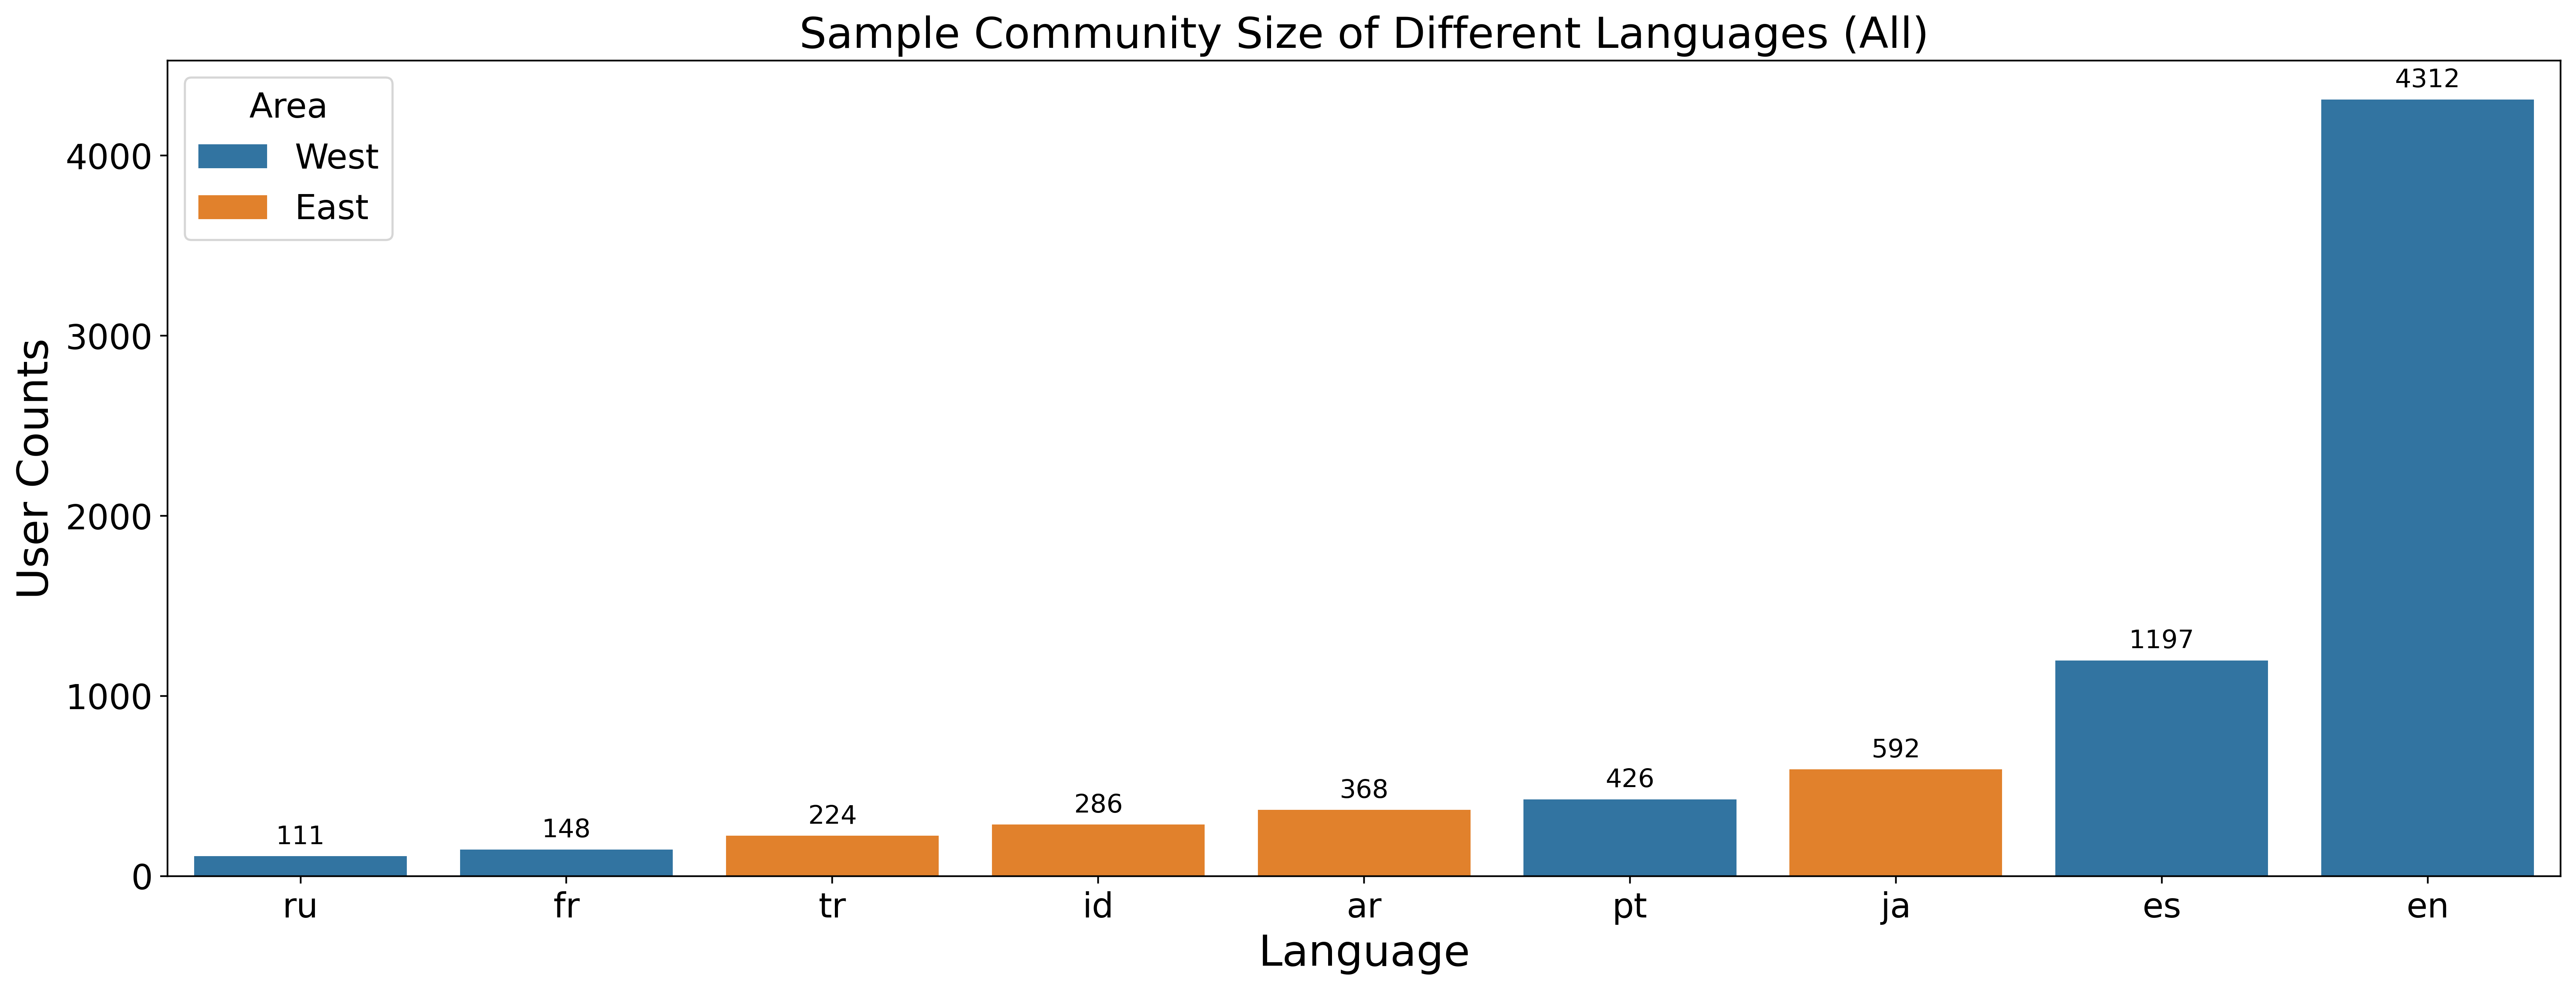

In [15]:
fig, ax = plt.subplots(figsize = (20, 7), dpi = 400)

#ax.set(yscale = 'log')
splot = sns.barplot(x = languages_stat.index, y = languages_stat['user_count'], hue = languages_stat['area'], ax = ax,
           dodge = False)
ax.set_xlabel('Language', fontsize = 20)
ax.set_ylabel('User Counts', fontsize = 20)
ax.set_title('Sample Community Size of Different Languages (All)', fontsize=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
plt.legend(title="Area", fontsize=16, title_fontsize=16)

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontsize = 12) 
#plt.savefig('img/community_size_all.jpg')
plt.show()

Conclusions, if any: 
1. Beware of log scale. Very high majority of < en > language users.
2. Top three western languages < en, es, pt > constitute ~75% of the total users. 
3. 9 western vs 5 eastern languages. 15,290 western vs 3,247 eastern users.

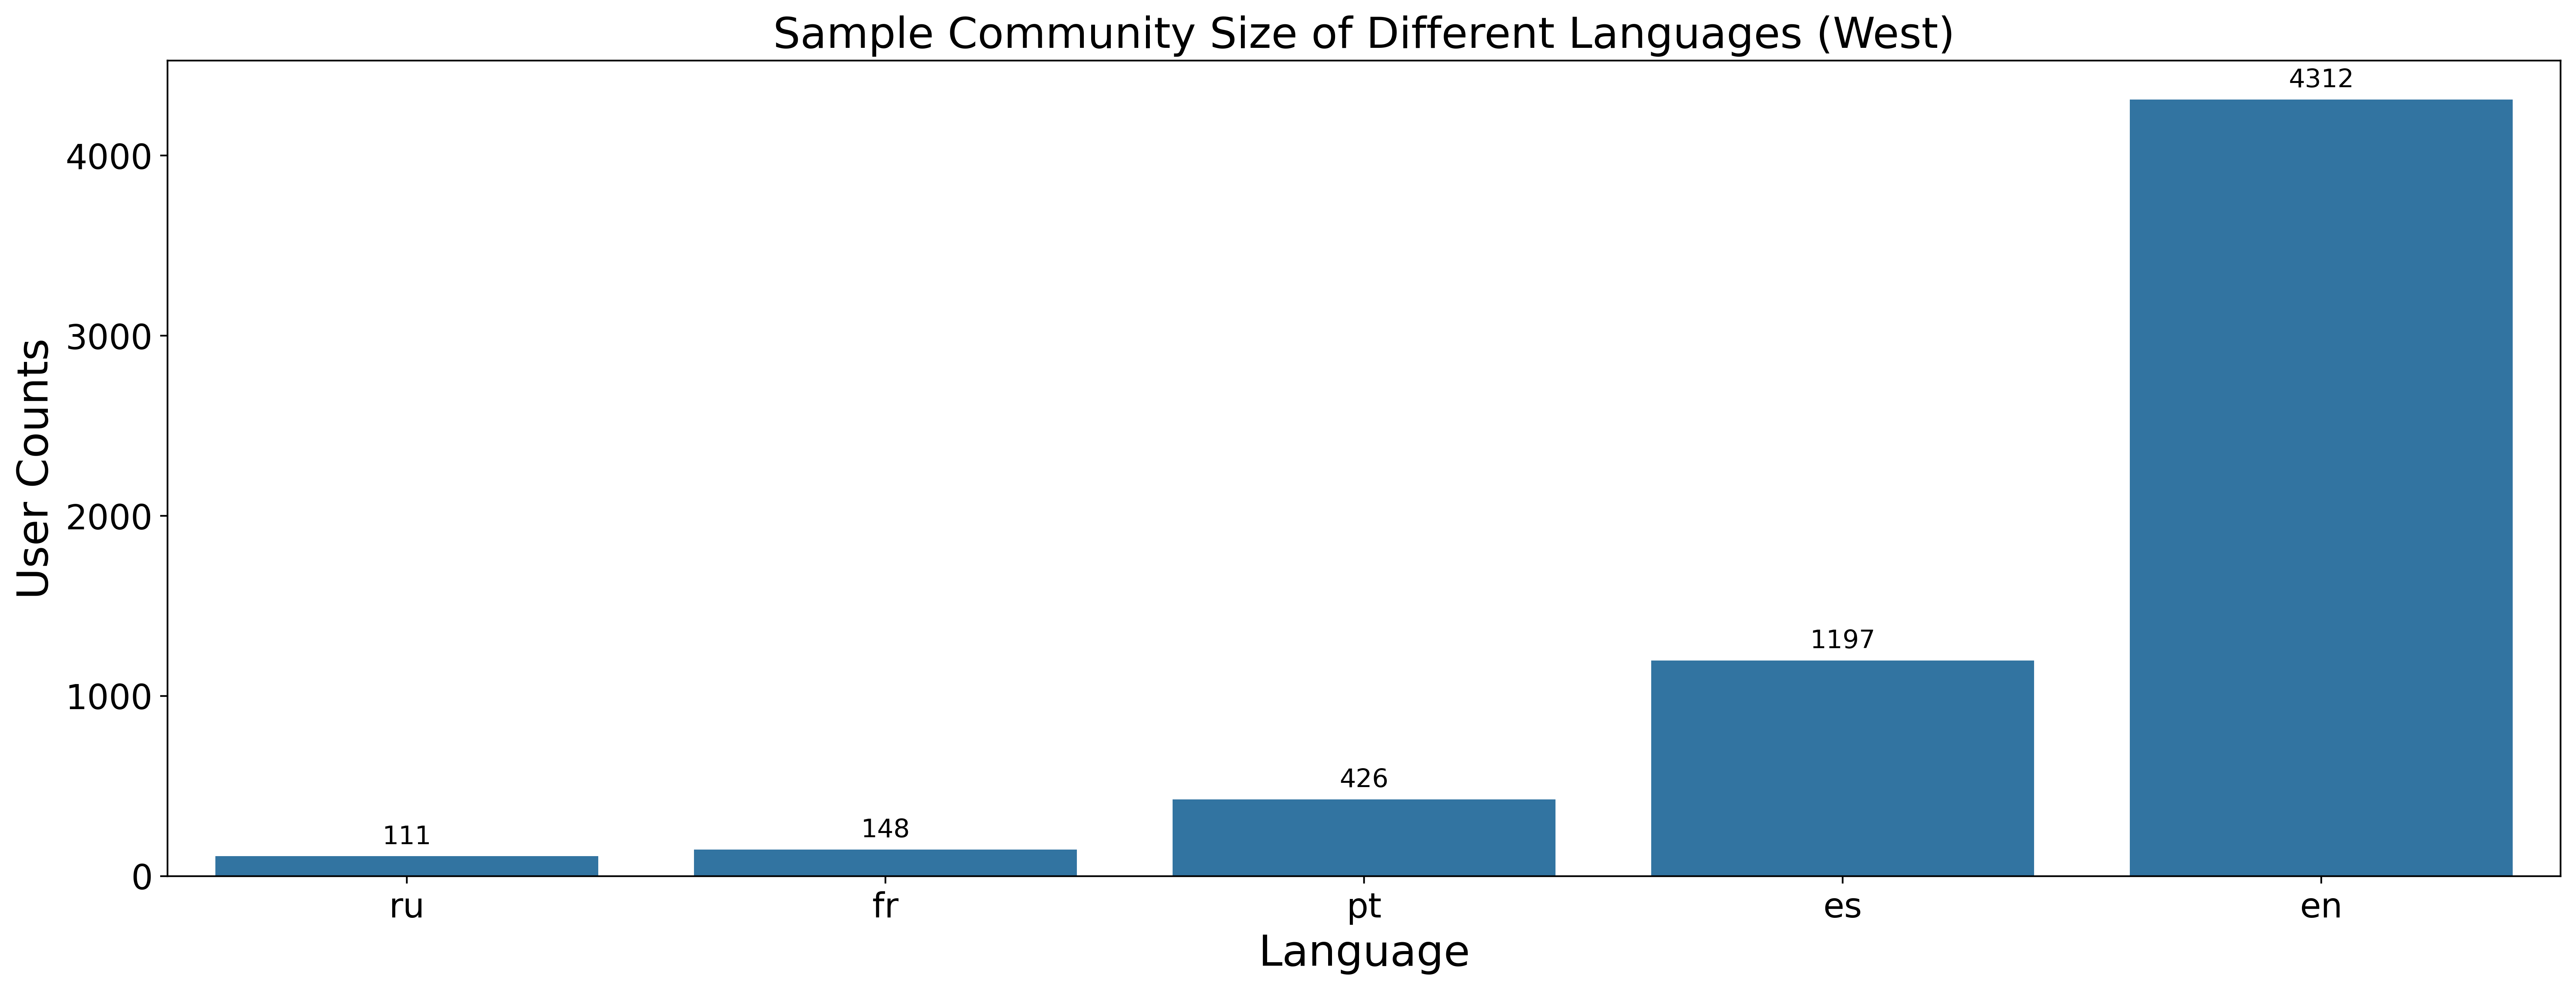

In [16]:
fig, ax = plt.subplots(figsize = (20, 7), dpi = 400)

languages_stat_west = languages_stat[languages_stat['area']=='West']

#ax.set(yscale = 'log')
splot = sns.barplot(x = languages_stat_west.index, y = languages_stat_west['user_count'], 
            color = sns.color_palette()[0], ax = ax, dodge = False)
ax.set_xlabel('Language', fontsize = 20)
ax.set_ylabel('User Counts', fontsize = 20)
ax.set_title('Sample Community Size of Different Languages (West)', fontsize=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontsize = 12) 

#plt.savefig('img/community_size_west.jpg')
plt.show()

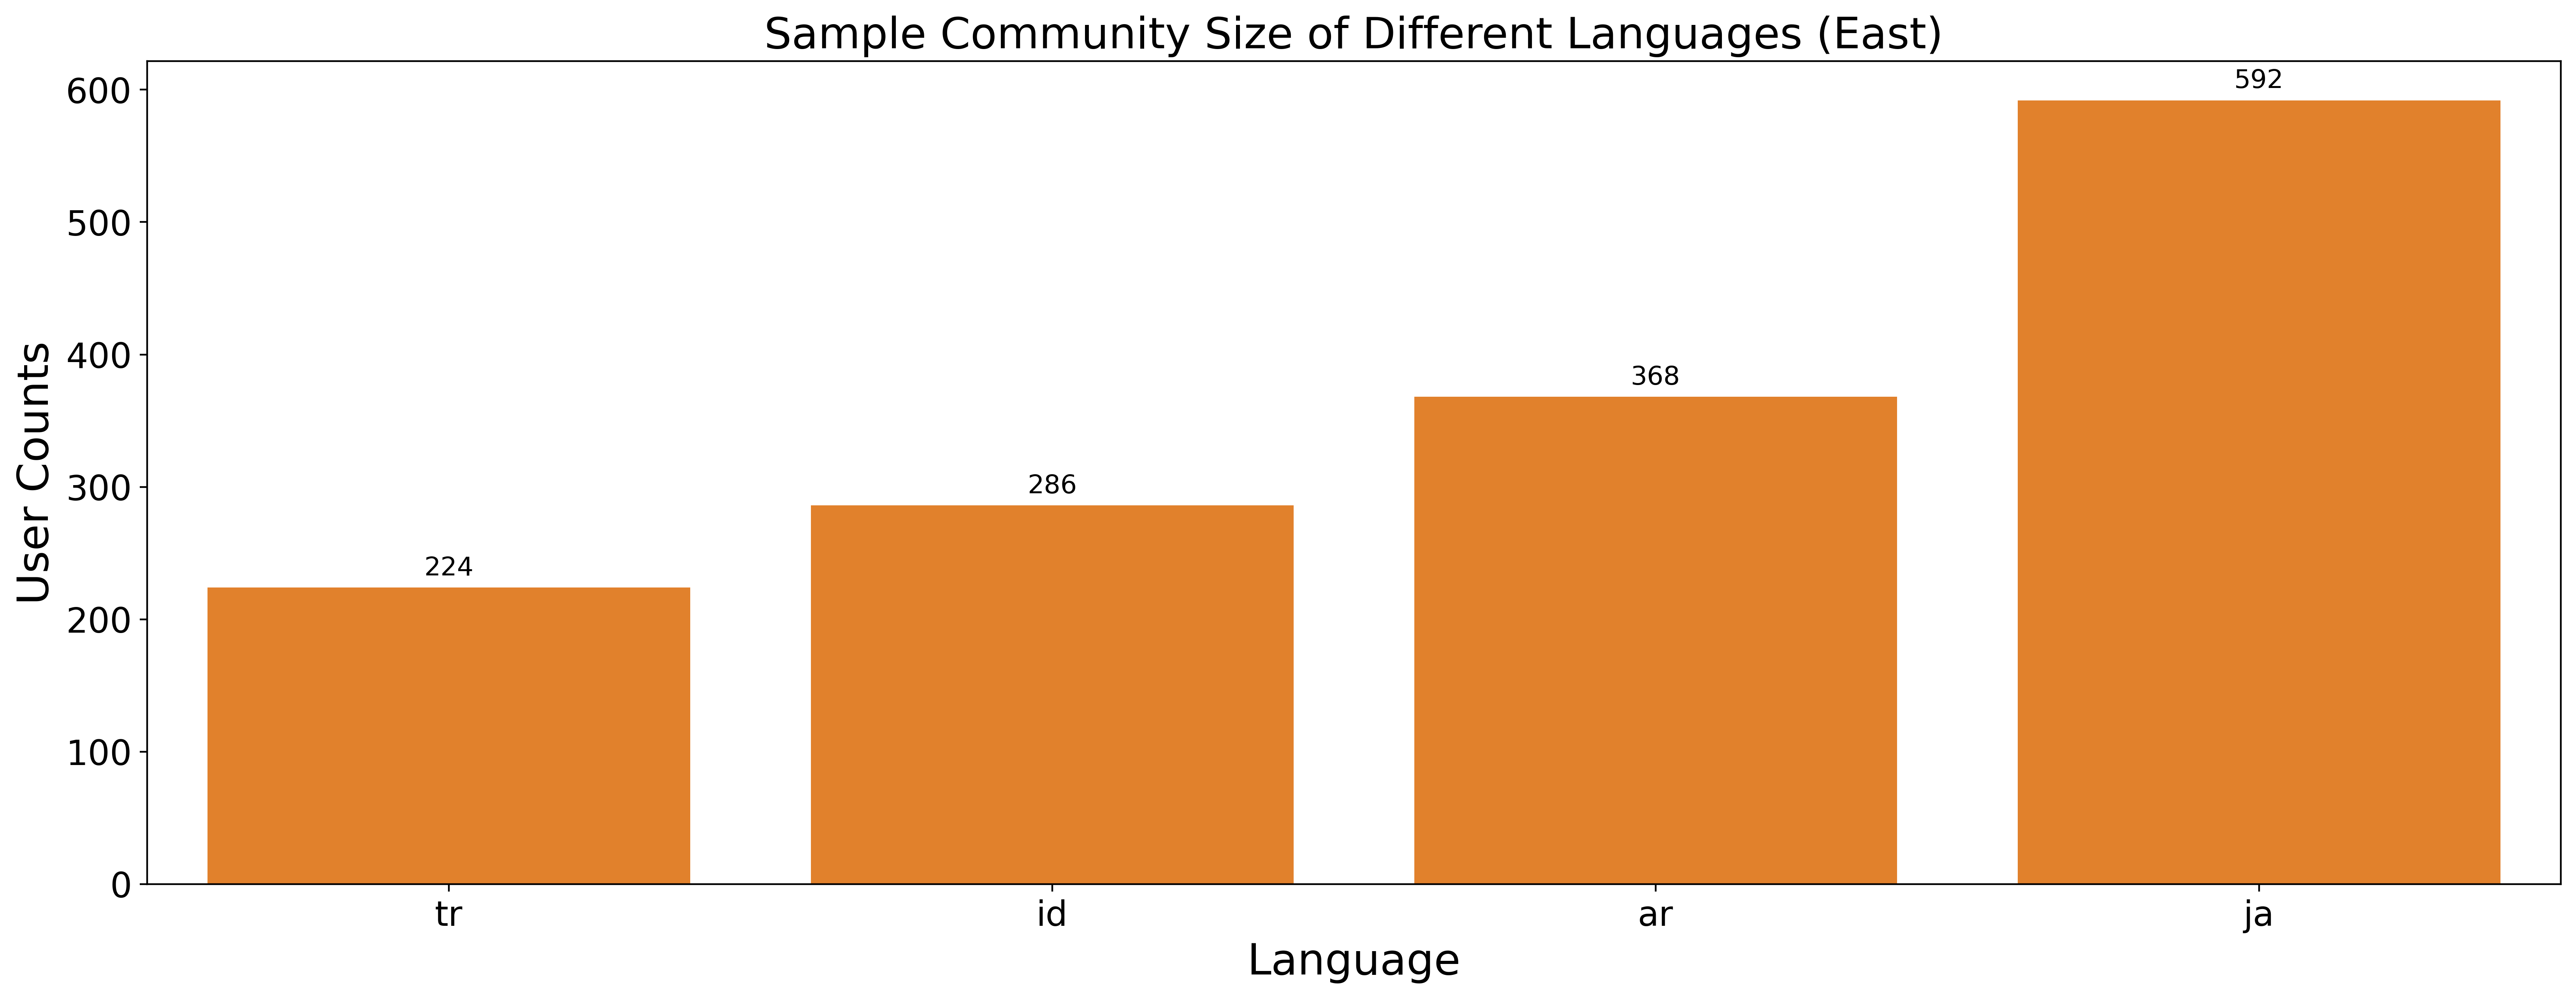

In [17]:
fig, ax = plt.subplots(figsize = (20, 7), dpi = 400)

languages_stat_east = languages_stat[languages_stat['area']=='East']

#ax.set(yscale = 'log')
splot = sns.barplot(x = languages_stat_east.index, y = languages_stat_east['user_count'], 
            color = sns.color_palette()[1], ax = ax, dodge = False)
ax.set_xlabel('Language', fontsize = 20)
ax.set_ylabel('User Counts', fontsize = 20)
ax.set_title('Sample Community Size of Different Languages (East)', fontsize=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontsize = 12,) 


#plt.savefig('img/community_size_east.jpg')
plt.show()

### Distribution of Different Languages

From the figures below, we can understand the distribution of the features of different languages.

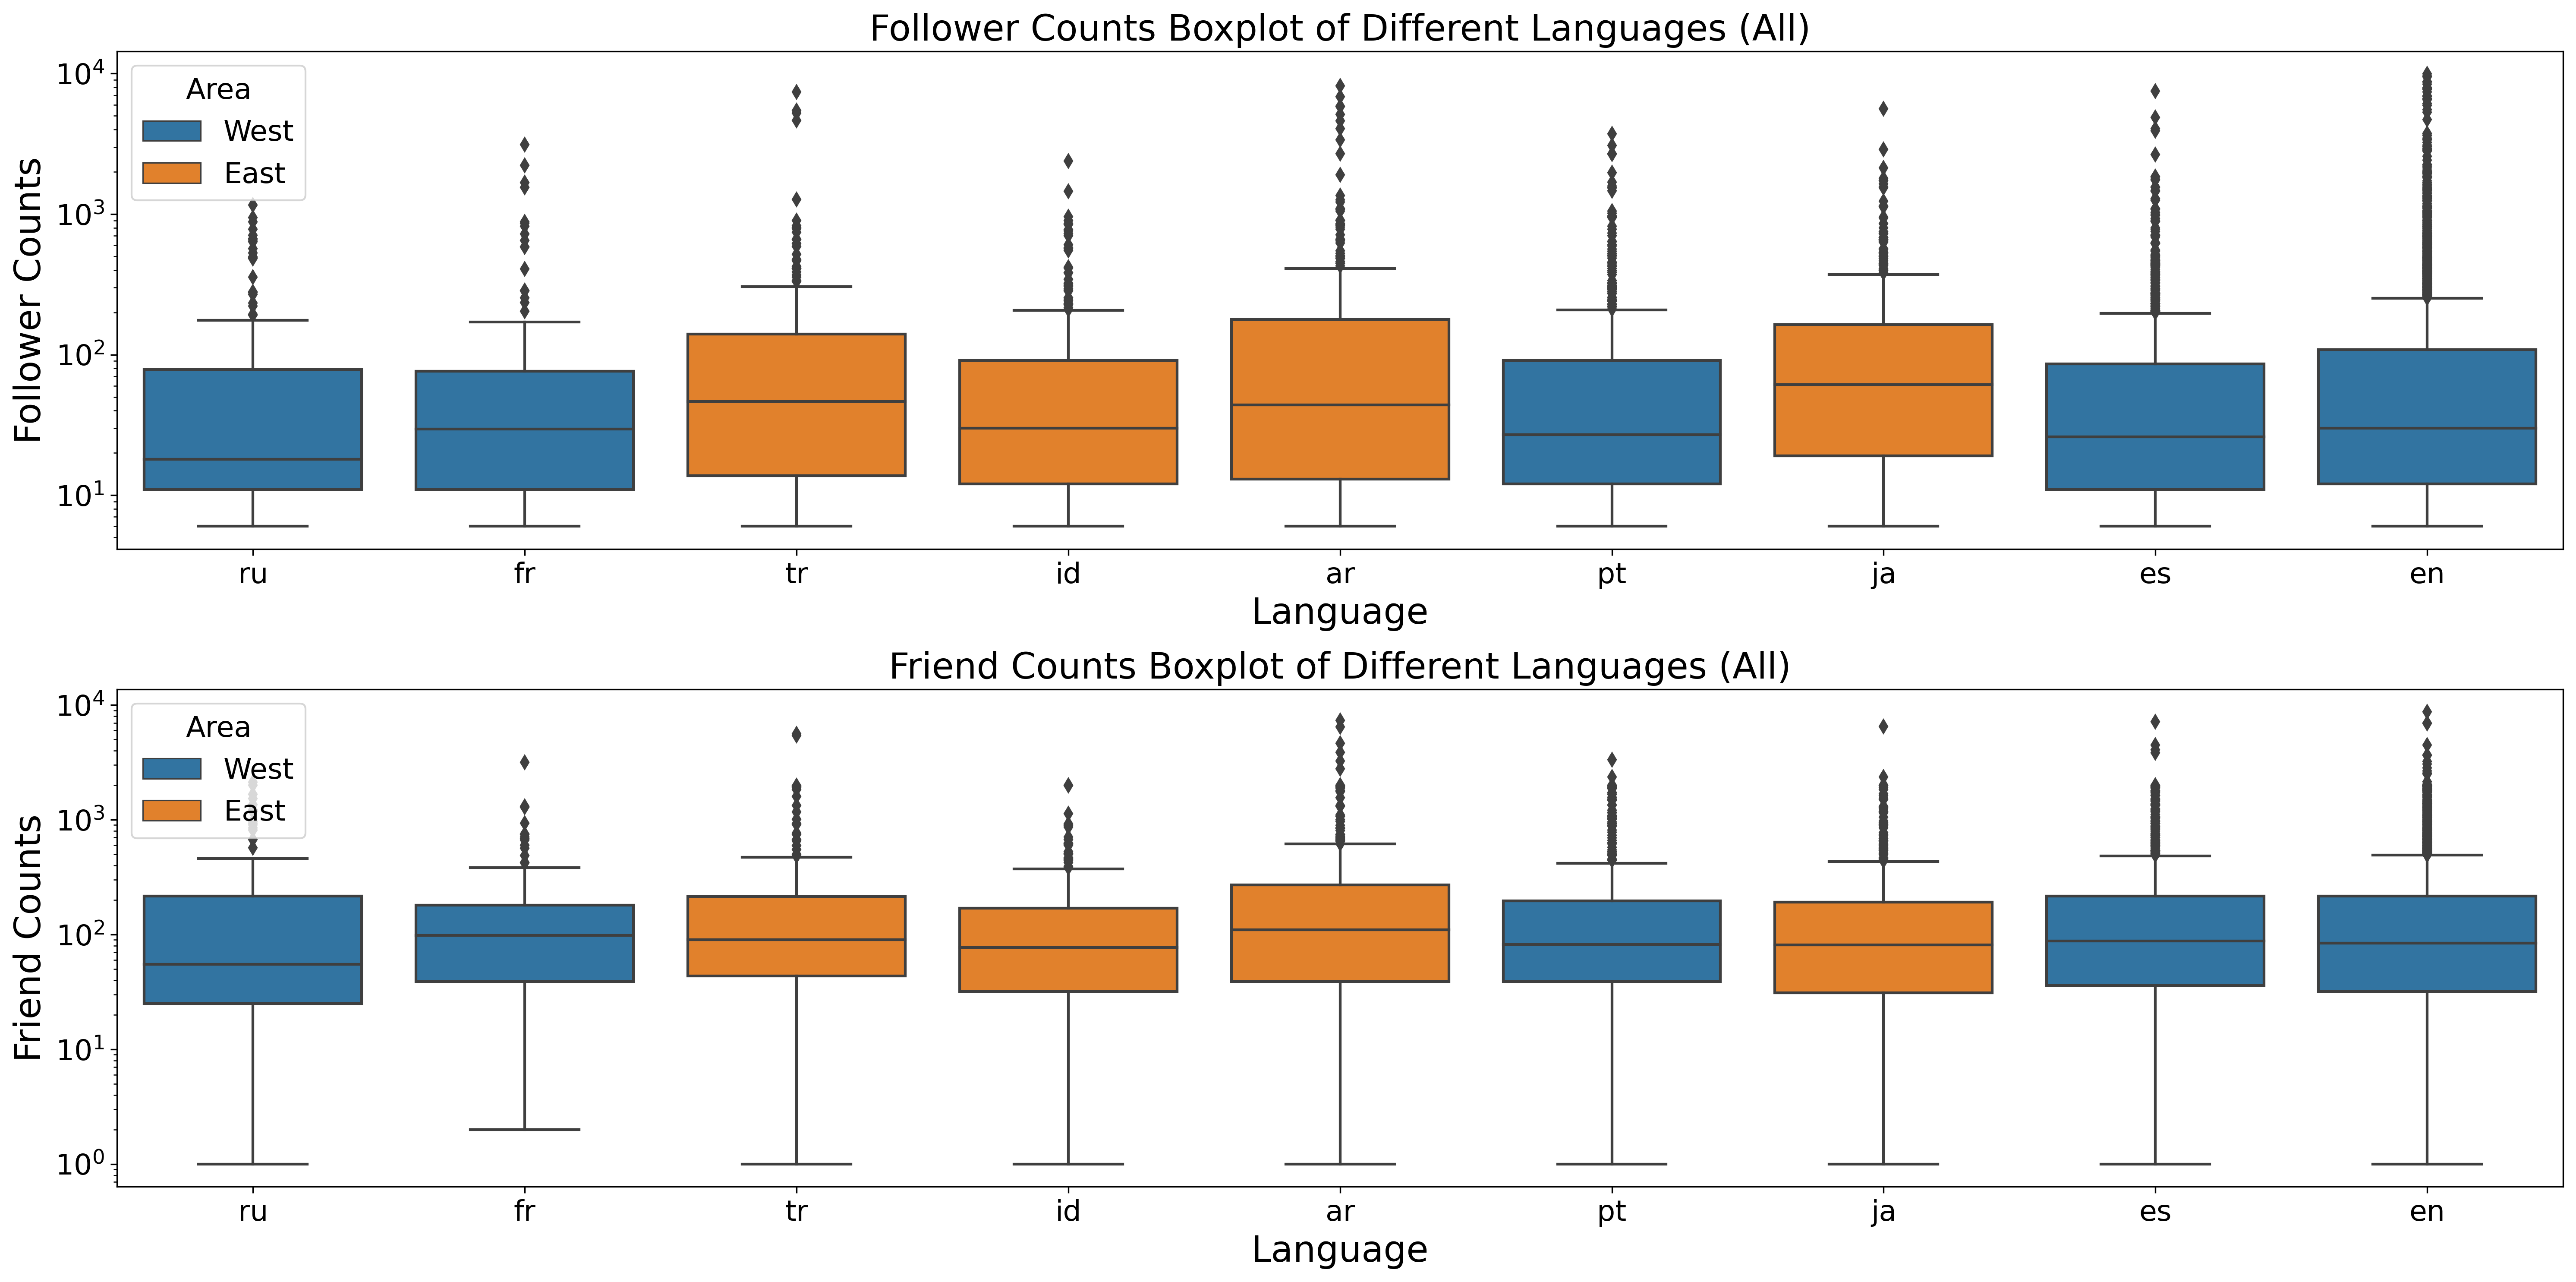

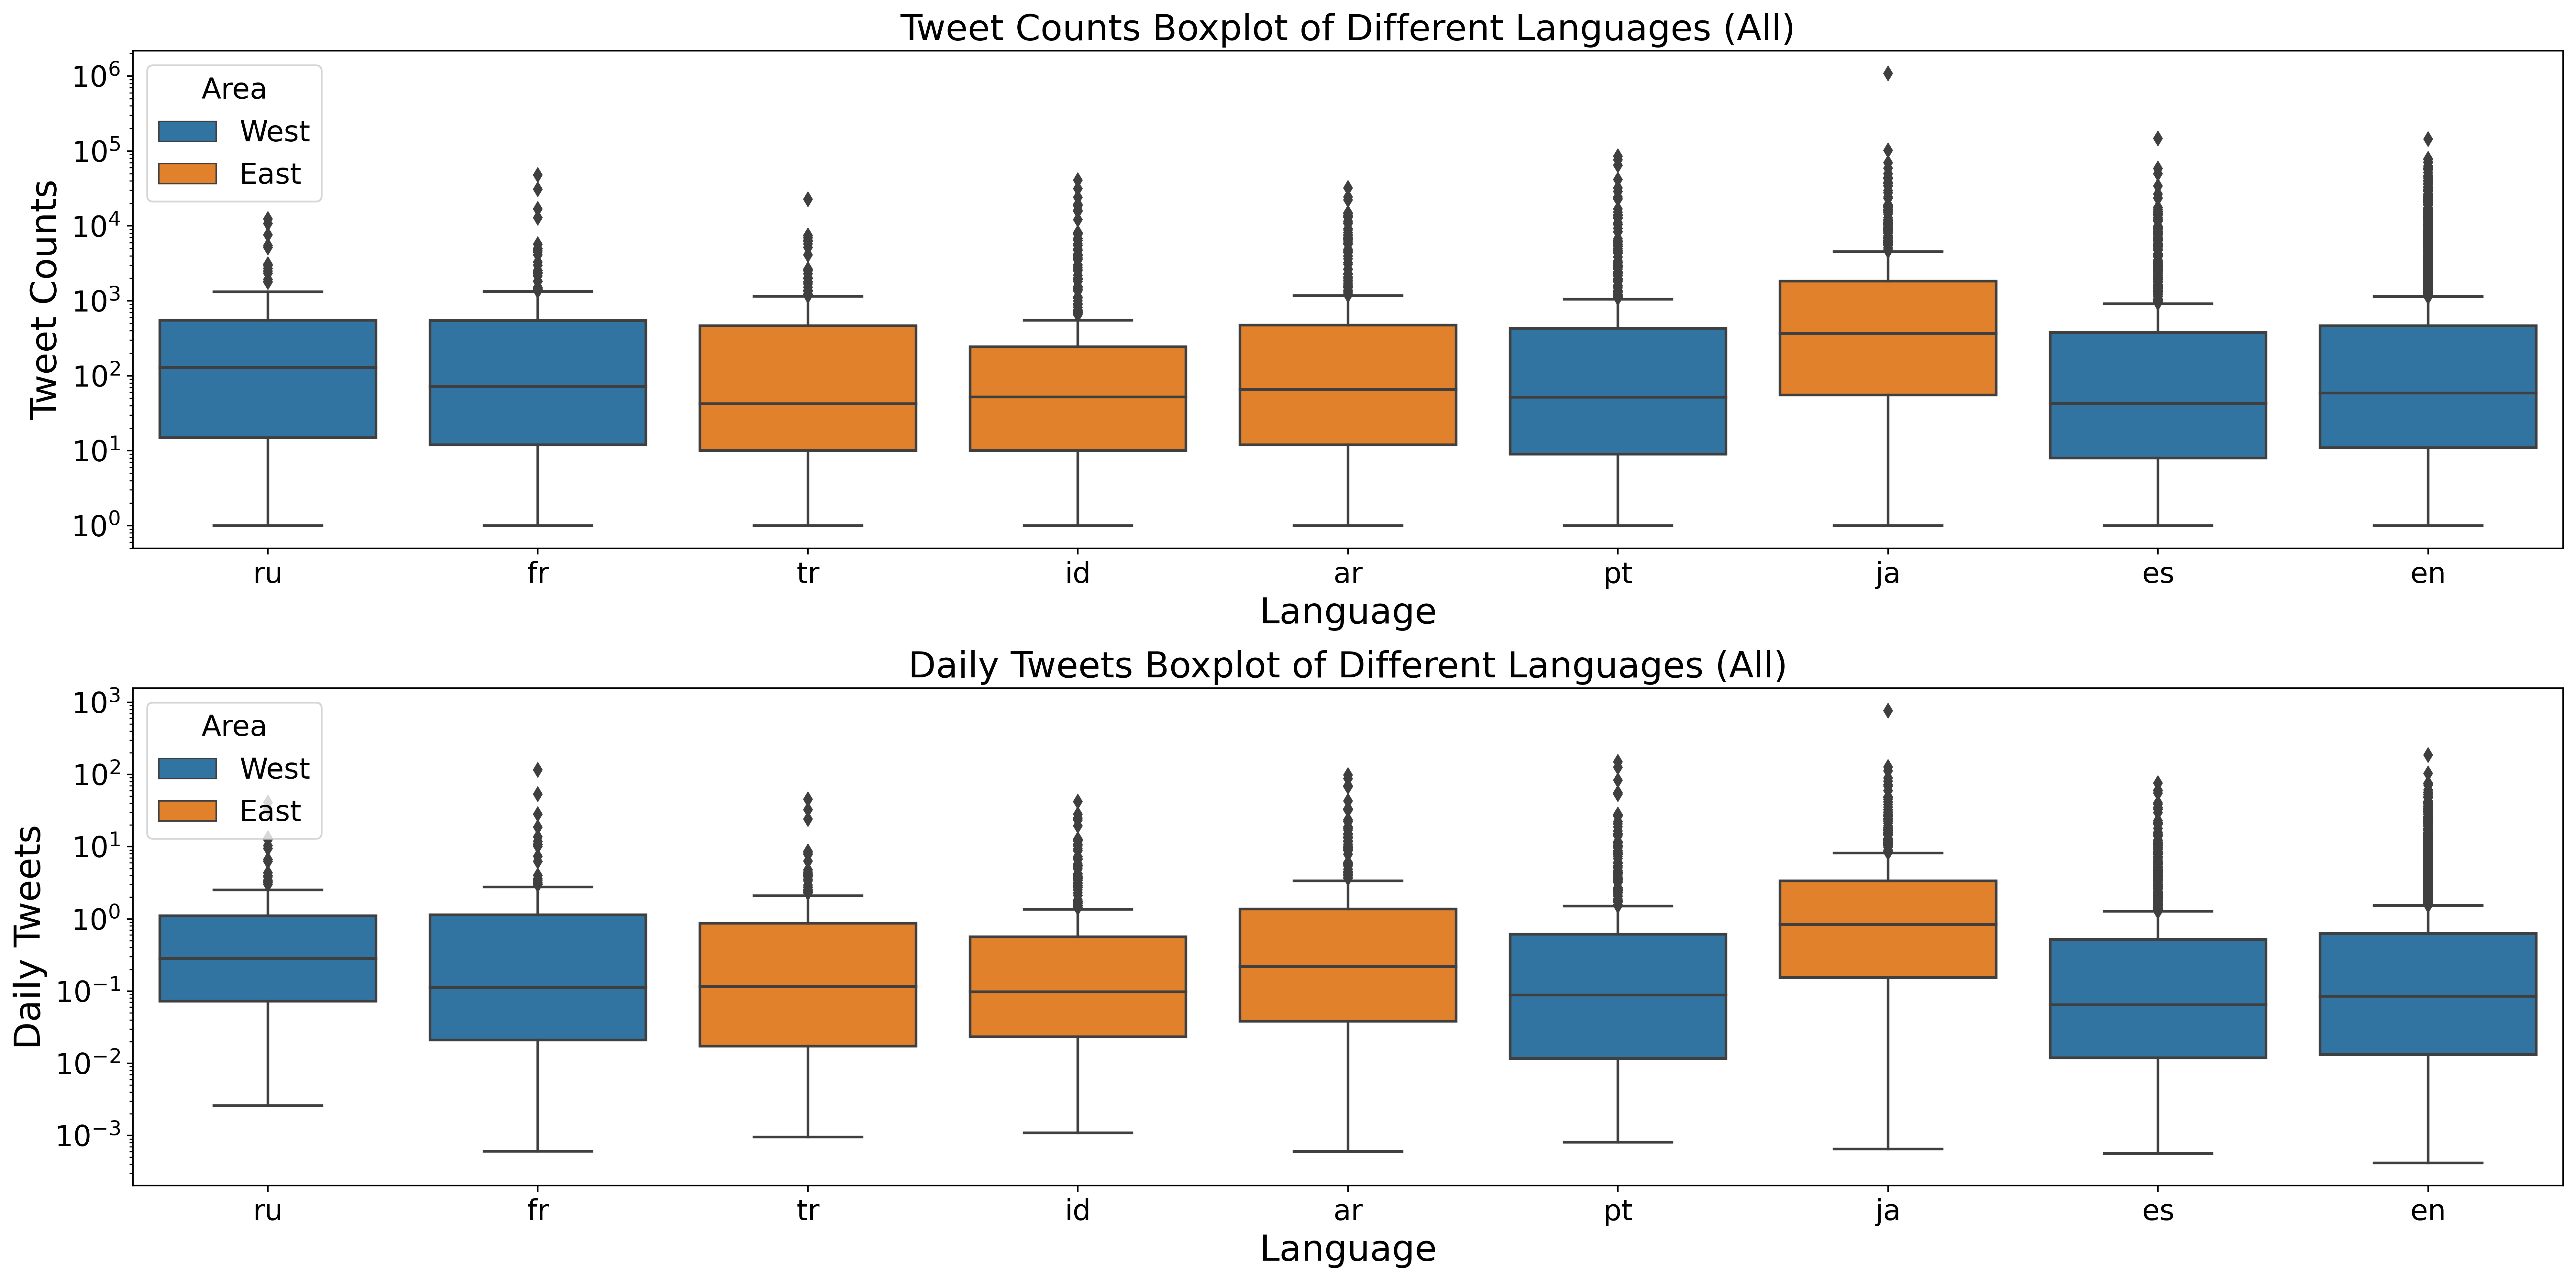

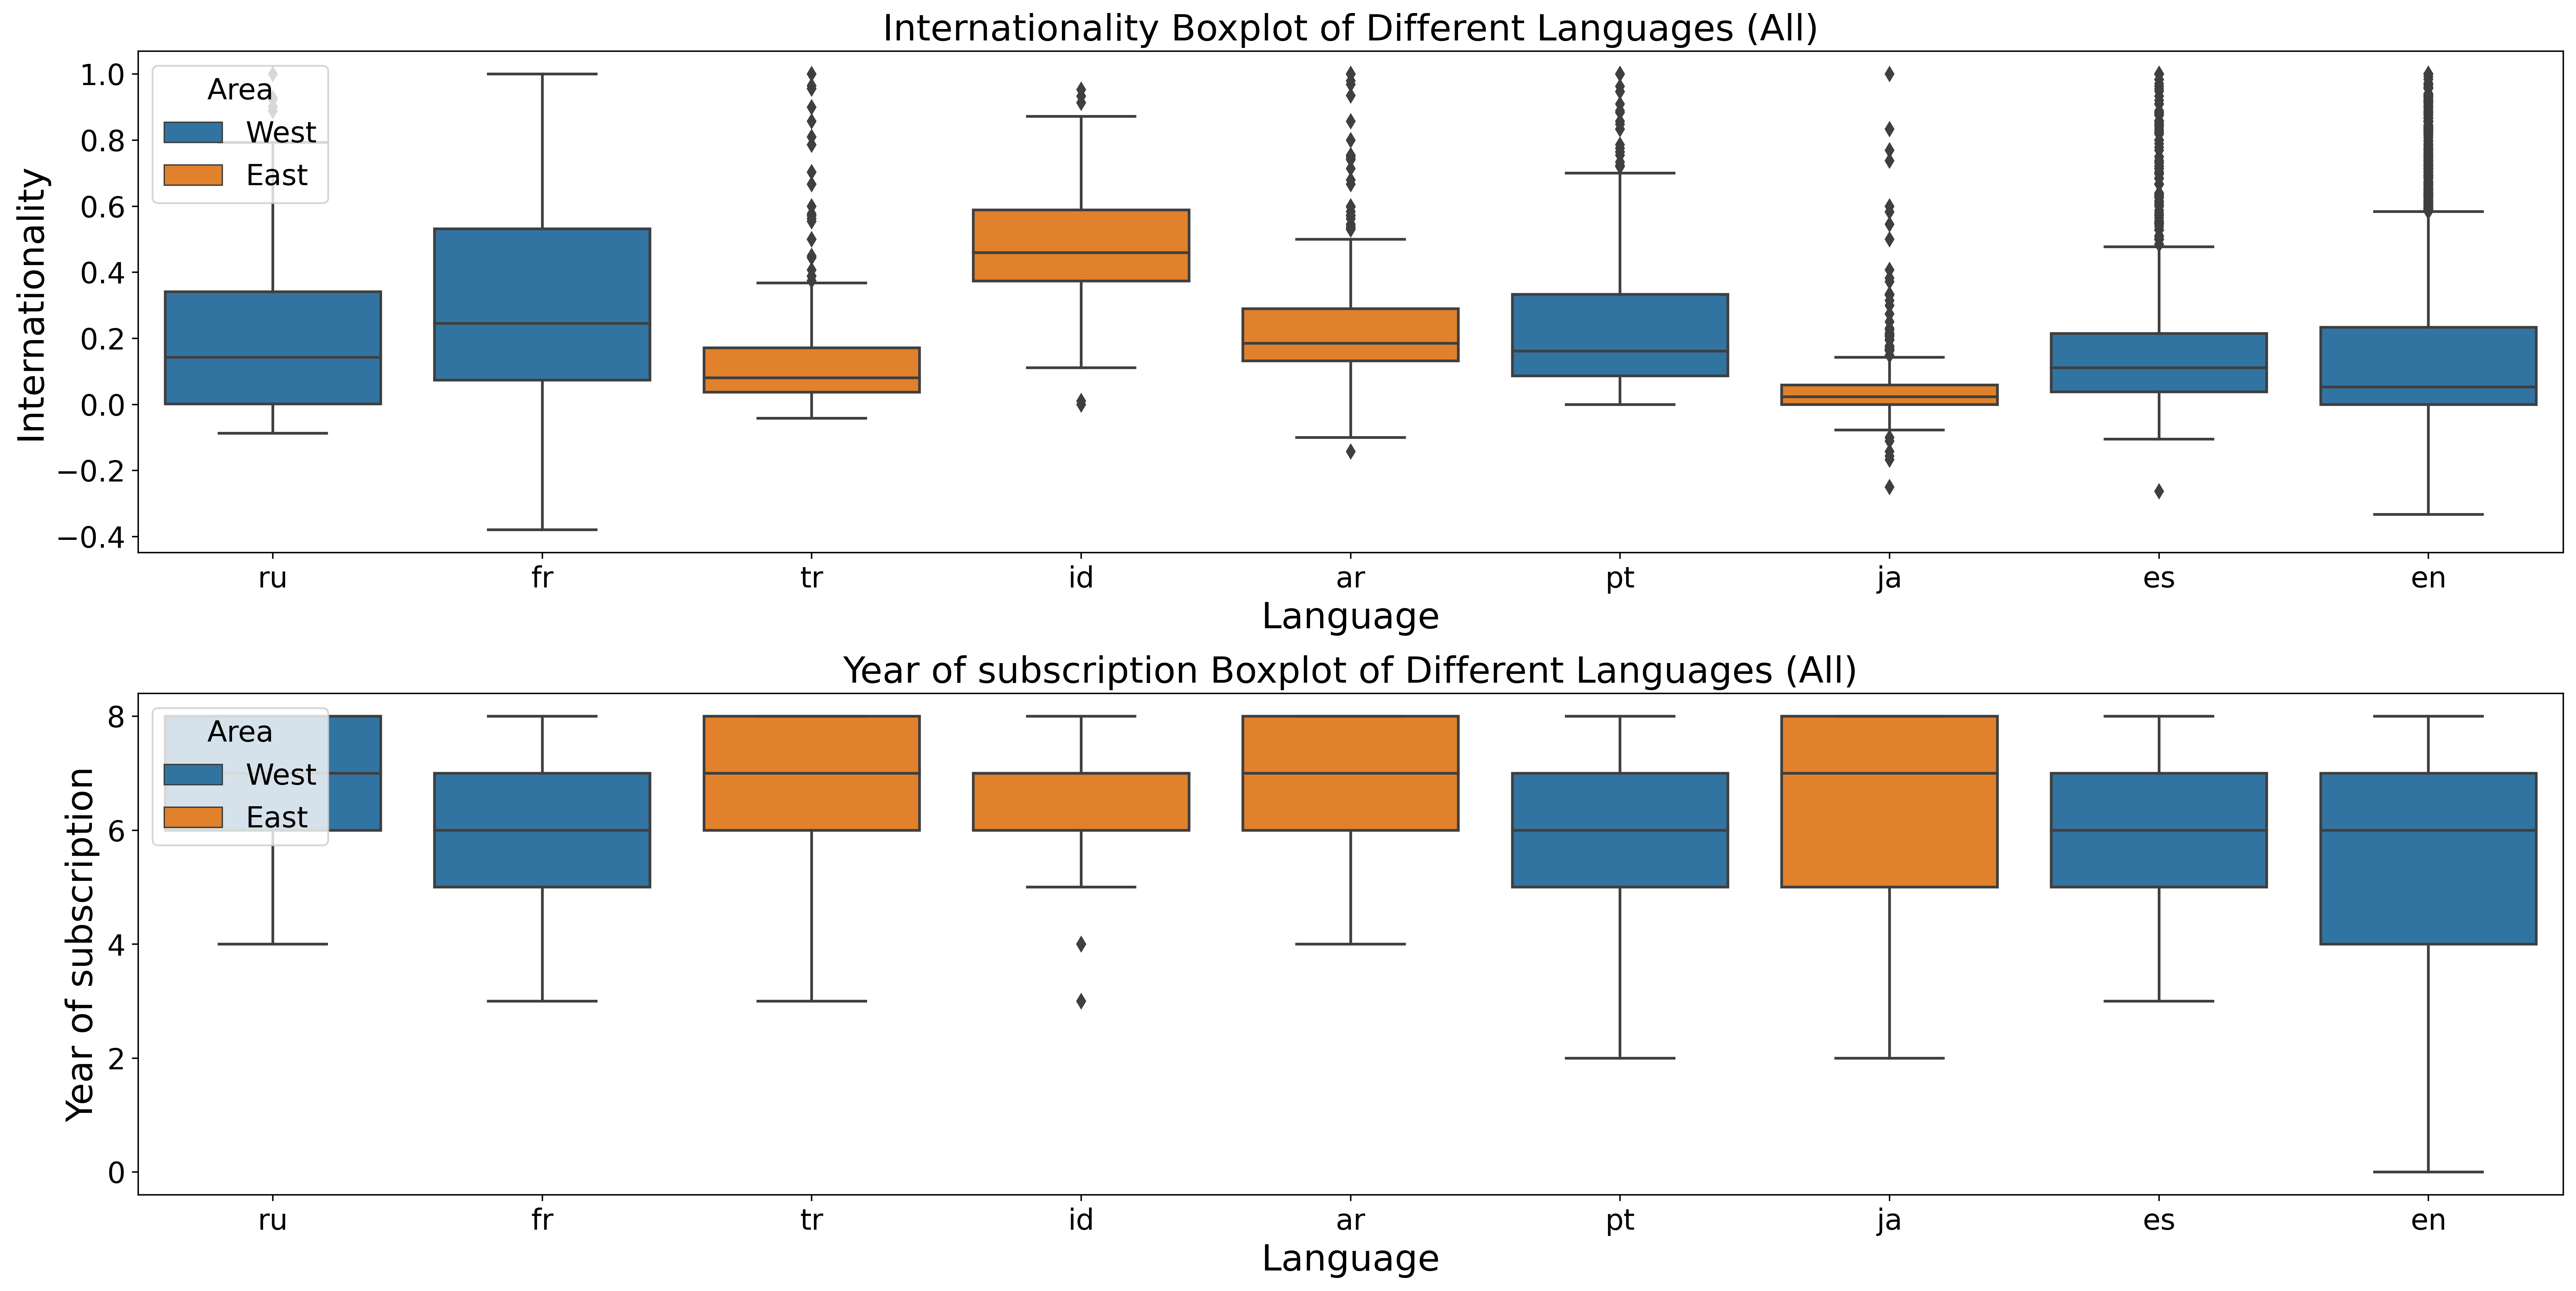

In [73]:
language_order = languages_stat.index.tolist()

# popularity

fig, ax = plt.subplots(2, 1, figsize = (20, 10), dpi = 300)

ax[0].set(yscale="log")
sns.boxplot(x = 'lang', y = 'followers_count', data = languages, order = language_order, ax = ax[0],
           hue = 'area', dodge = False)
ax[0].set_xlabel('Language', fontsize = 20)
ax[0].set_ylabel('Follower Counts', fontsize = 20)
ax[0].set_title('Follower Counts Boxplot of Different Languages (All)', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)
ax[0].legend(title="Area", fontsize=16, title_fontsize=16, loc = 2)

ax[1].set(yscale="log")
sns.boxplot(x = 'lang', y = 'friends_count', data = languages, order = language_order, ax = ax[1],
           hue = 'area', dodge = False)
ax[1].set_xlabel('Language', fontsize = 20)
ax[1].set_ylabel('Friend Counts', fontsize = 20)
ax[1].set_title('Friend Counts Boxplot of Different Languages (All)', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)
ax[1].legend(title="Area", fontsize=16, title_fontsize=16, loc = 2)

fig.tight_layout()
#plt.savefig("img/popularity_statistics_boxplot.jpg")

# activness

fig, ax = plt.subplots(2, 1, figsize = (20, 10), dpi = 400)

ax[0].set(yscale="log")
sns.boxplot(x = 'lang', y = 'statuses_count', data = languages, order = language_order, ax = ax[0],
           hue = 'area', dodge = False)
ax[0].set_xlabel('Language', fontsize = 20)
ax[0].set_ylabel('Tweet Counts', fontsize = 20)
ax[0].set_title('Tweet Counts Boxplot of Different Languages (All)', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)
ax[0].legend(title="Area", fontsize=16, title_fontsize=16, loc = 2)

ax[1].set(yscale="log")
sns.boxplot(x = 'lang', y = 'avg_daily_tweets', data = languages, order = language_order, ax = ax[1],
           hue = 'area', dodge = False)
ax[1].set_xlabel('Language', fontsize = 20)
ax[1].set_ylabel('Daily Tweets', fontsize = 20)
ax[1].set_title('Daily Tweets Boxplot of Different Languages (All)', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)
ax[1].legend(title="Area", fontsize=16, title_fontsize=16, loc = 2)

fig.tight_layout()
#plt.savefig("img/activeness_statistics_boxplot.jpg")

fig, ax = plt.subplots(2, 1, figsize = (20, 10), dpi = 400)

#ax[0].set(yscale="log")
sns.boxplot(x = 'lang', y = 'Internationality', data = languages, order = language_order, ax = ax[0],
           hue = 'area', dodge = False)
ax[0].set_xlabel('Language', fontsize = 20)
ax[0].set_ylabel('Internationality', fontsize = 20)
ax[0].set_title('Internationality Boxplot of Different Languages (All)', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)
ax[0].legend(title="Area", fontsize=16, title_fontsize=16, loc = 2)

#ax[1].set(yscale="log")
sns.boxplot(x = 'lang', y = 'year', data = languages, order = language_order, ax = ax[1],
           hue = 'area', dodge = False)
ax[1].set_xlabel('Language', fontsize = 20)
ax[1].set_ylabel('Year of subscription', fontsize = 20)
ax[1].set_title('Year of subscription Boxplot of Different Languages (All)', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)
ax[1].legend(title="Area", fontsize=16, title_fontsize=16, loc = 2)

fig.tight_layout()
#plt.savefig("img/activeness_statistics_boxplot.jpg")

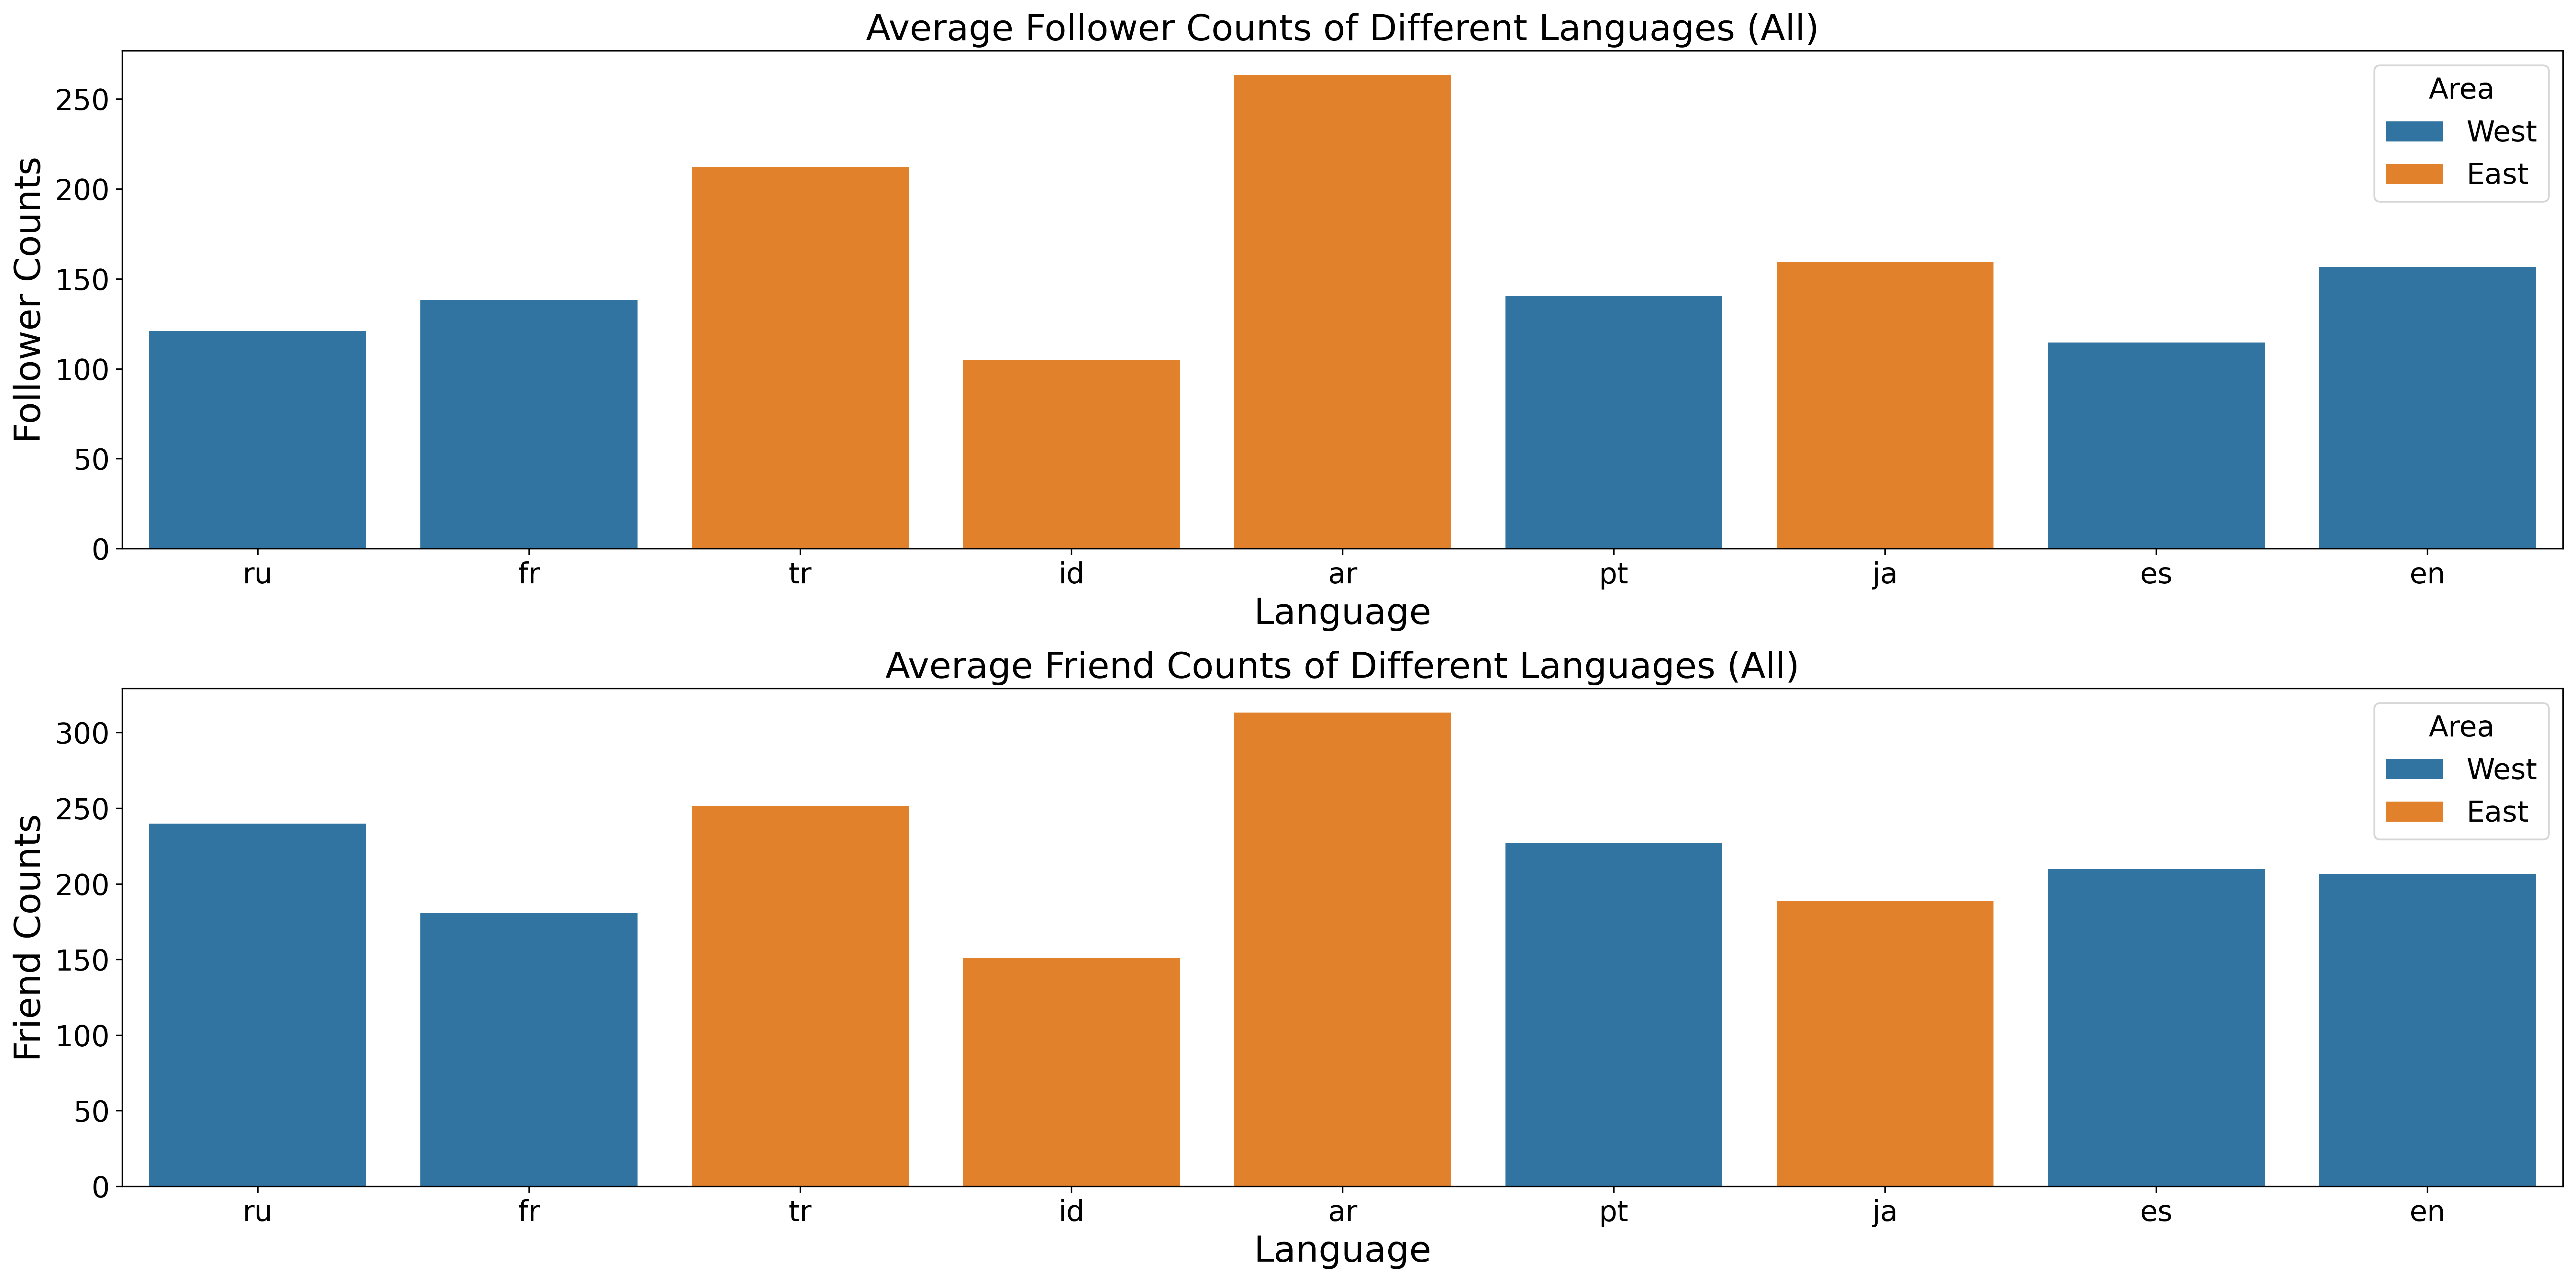

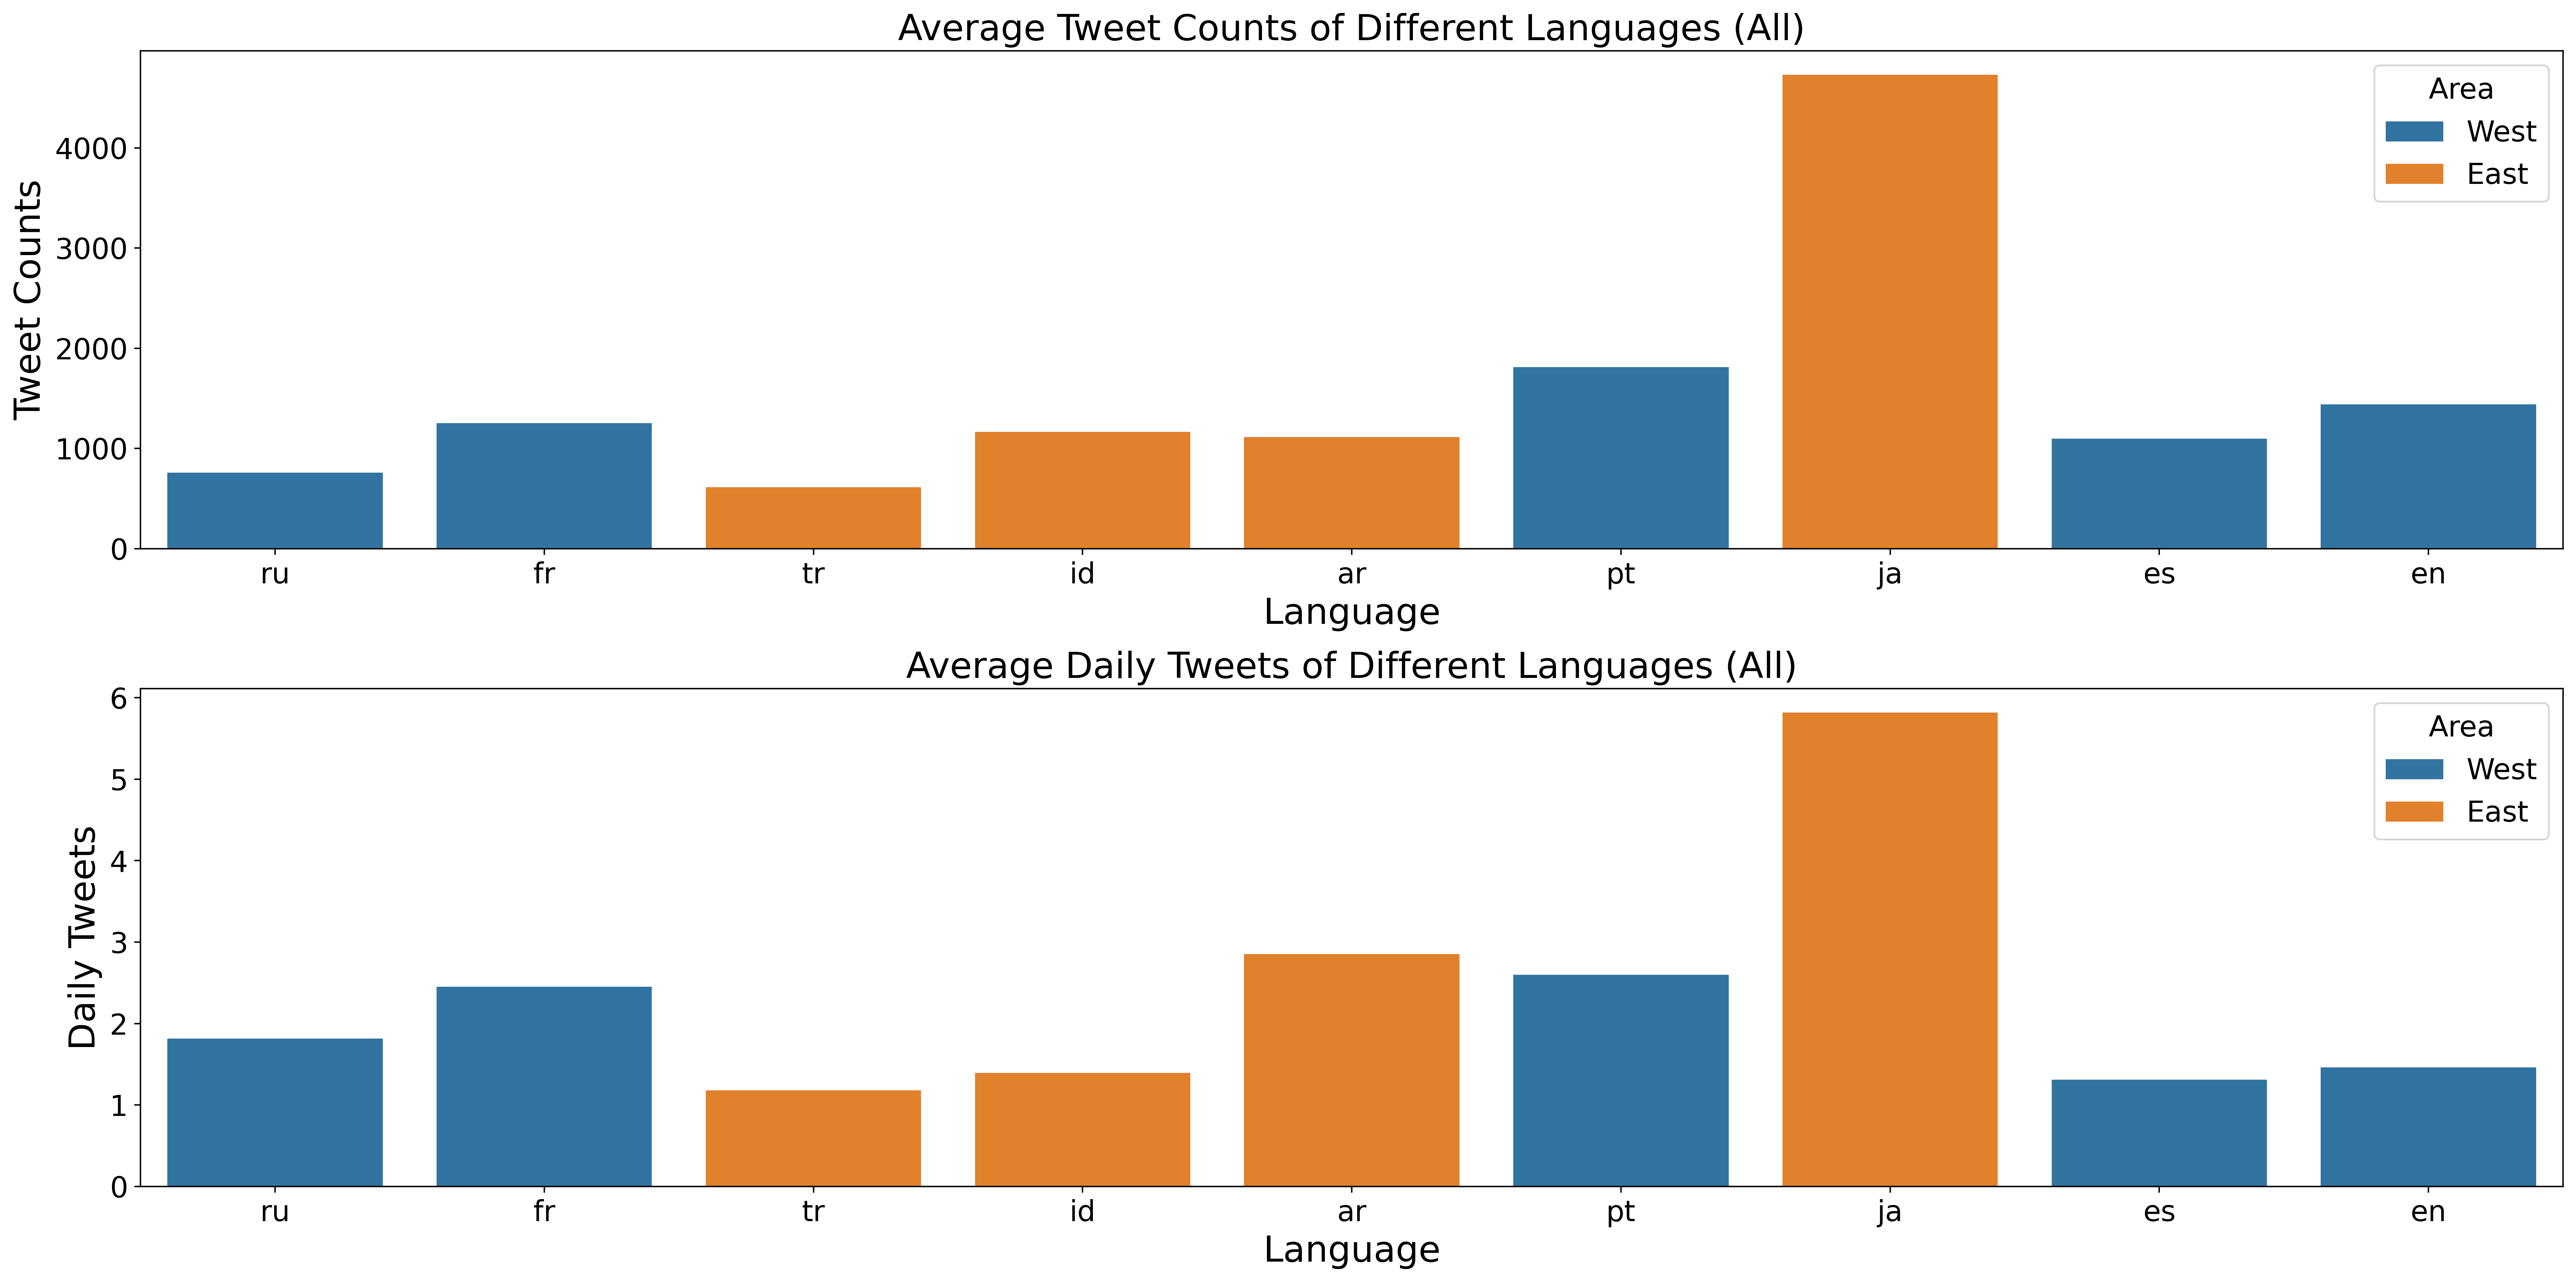

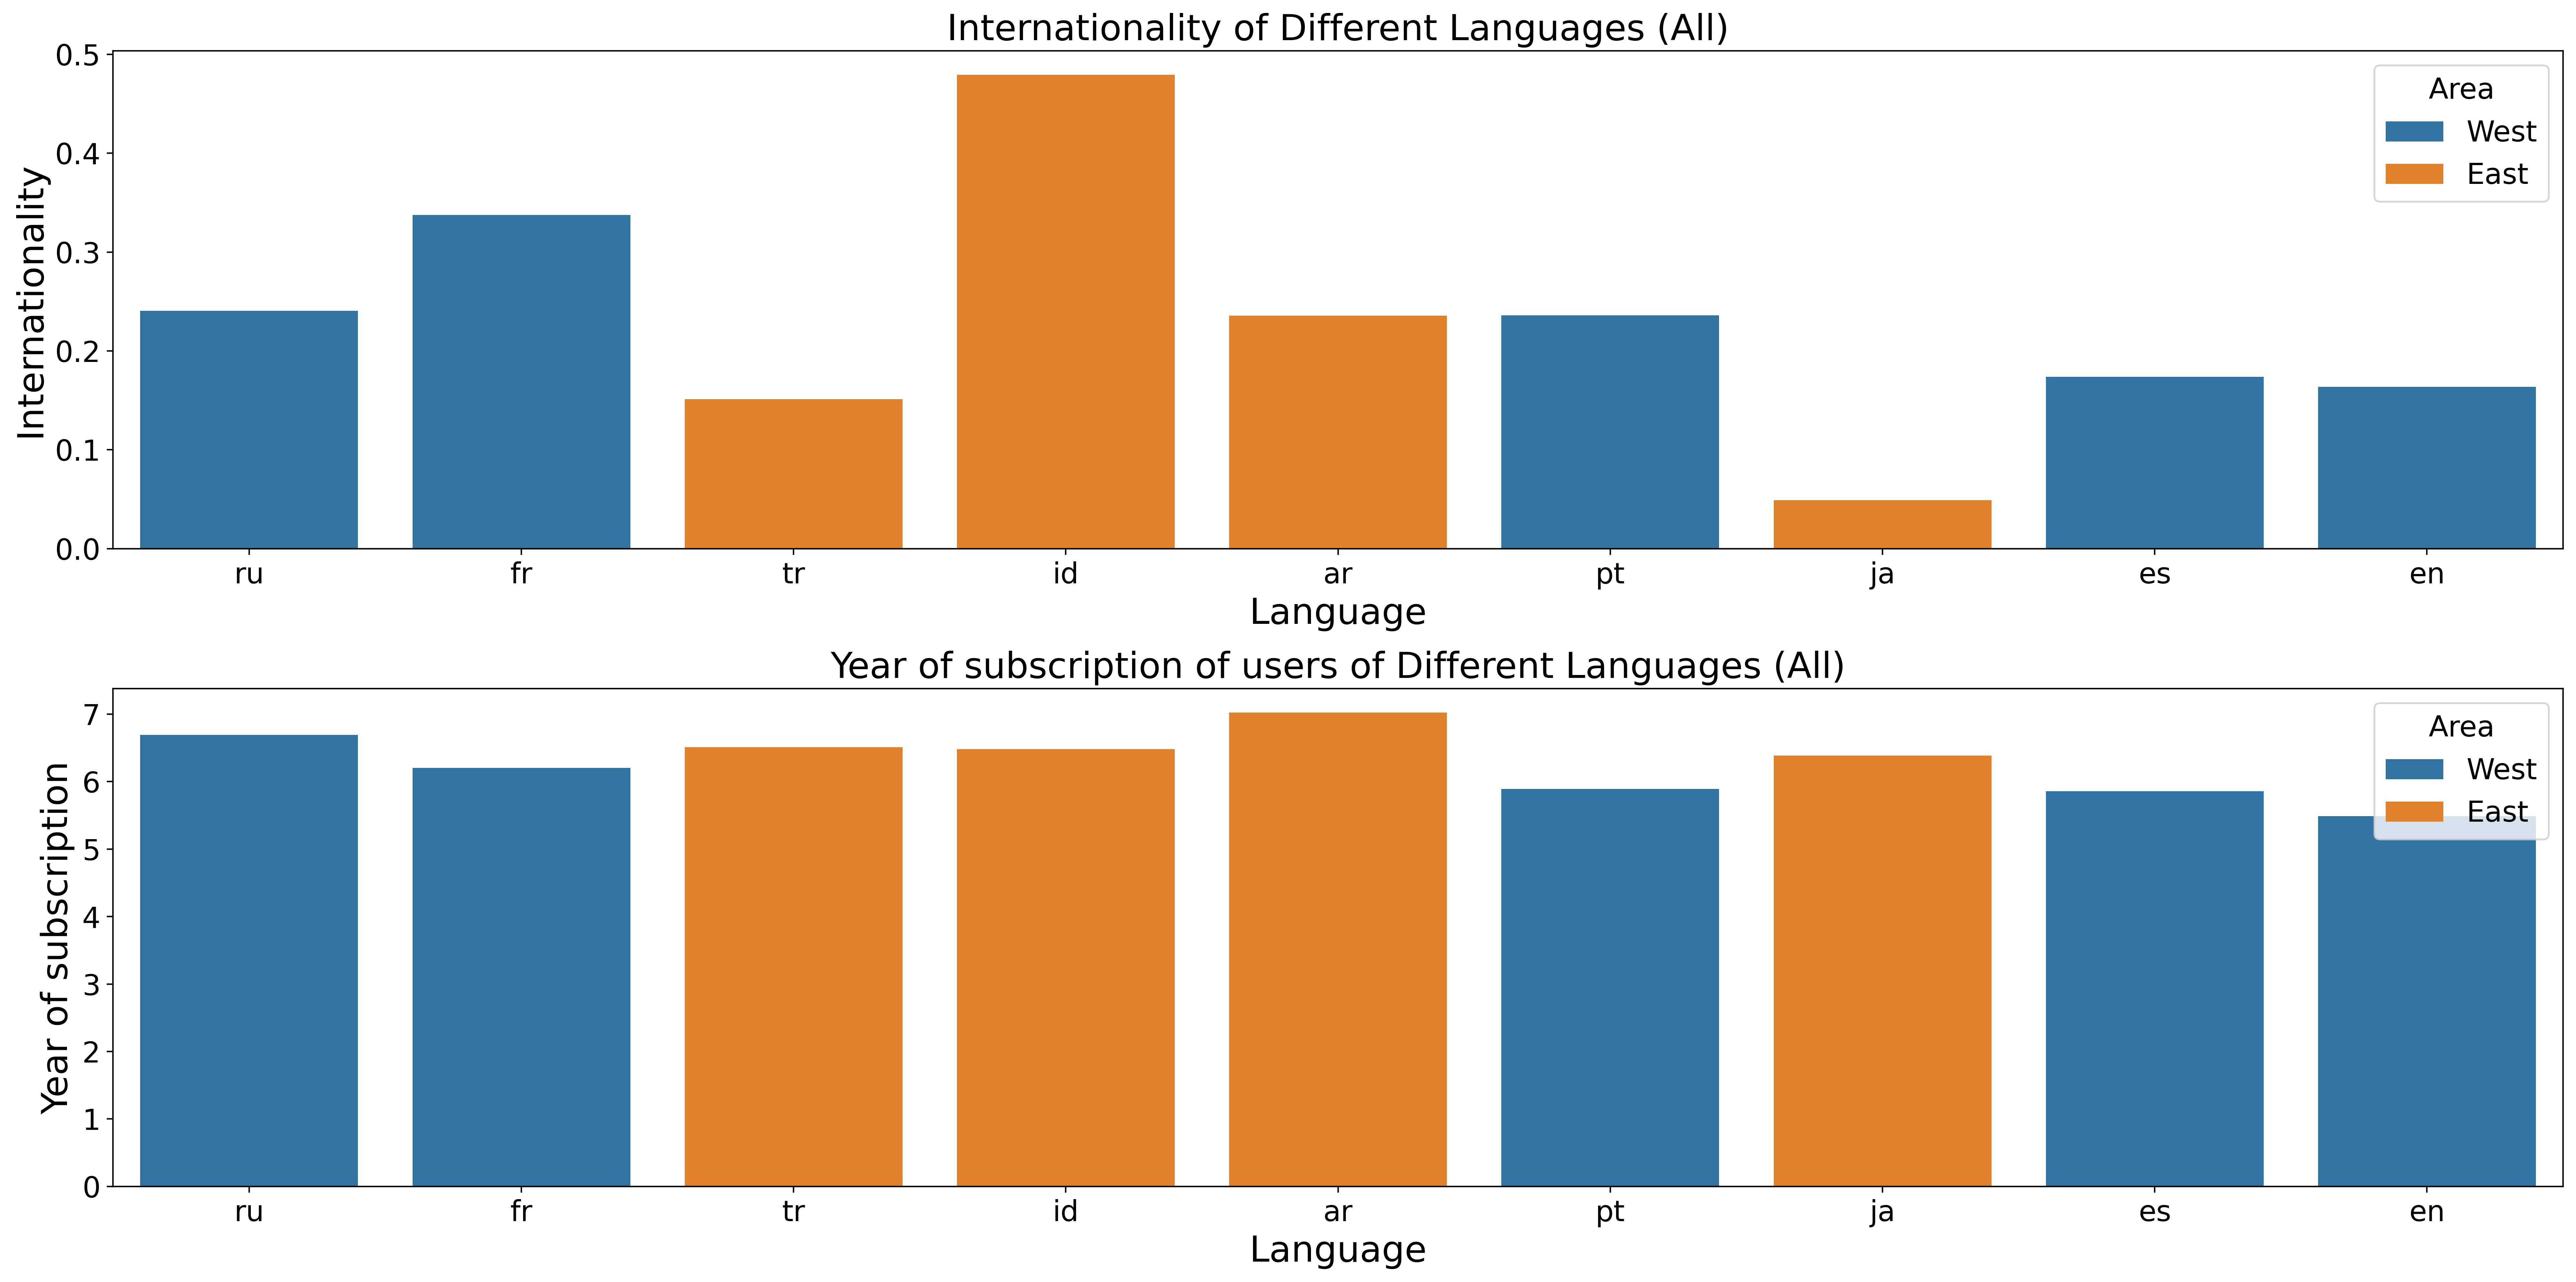

In [19]:
language_order = languages_stat.index.tolist()

fig, ax = plt.subplots(2, 1, figsize = (20, 10), dpi = 400)

#ax[0].set(yscale="log")
sns.barplot(x = languages_stat.index, y = languages_stat['followers_count'], hue = languages_stat['area'], ax = ax[0],
           dodge = False)
ax[0].set_xlabel('Language', fontsize = 20)
ax[0].set_ylabel('Follower Counts', fontsize = 20)
ax[0].set_title('Average Follower Counts of Different Languages (All)', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)
ax[0].legend(title="Area", fontsize=16, title_fontsize=16, loc = 1)

#ax[1].set(yscale="log")
sns.barplot(x = languages_stat.index, y = languages_stat['friends_count'], hue = languages_stat['area'], ax = ax[1],
           dodge = False)
ax[1].set_xlabel('Language', fontsize = 20)
ax[1].set_ylabel('Friend Counts', fontsize = 20)
ax[1].set_title('Average Friend Counts of Different Languages (All)', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)
ax[1].legend(title="Area", fontsize=16, title_fontsize=16, loc = 1)

fig.tight_layout()
#plt.savefig("img/popularity_statistics_barplot.jpg")

fig, ax = plt.subplots(2, 1, figsize = (20, 10), dpi = 400)

#ax[2].set(yscale="log")
sns.barplot(x = languages_stat.index, y = languages_stat['statuses_count'], hue = languages_stat['area'], ax = ax[0],
           dodge = False)
ax[0].set_xlabel('Language', fontsize = 20)
ax[0].set_ylabel('Tweet Counts', fontsize = 20)
ax[0].set_title('Average Tweet Counts of Different Languages (All)', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)
ax[0].legend(title="Area", fontsize=16, title_fontsize=16, loc = 1)

#ax[3].set(yscale="log")
sns.barplot(x = languages_stat.index, y = languages_stat['avg_daily_tweets'], hue = languages_stat['area'], ax = ax[1],
           dodge = False)
ax[1].set_xlabel('Language', fontsize = 20)
ax[1].set_ylabel('Daily Tweets', fontsize = 20)
ax[1].set_title('Average Daily Tweets of Different Languages (All)', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)
ax[1].legend(title="Area", fontsize=16, title_fontsize=16, loc = 1)

fig.tight_layout()
#plt.savefig("img/activeness_statistics_barplot.jpg")

fig, ax = plt.subplots(2, 1, figsize = (20, 10), dpi = 400)

#ax[2].set(yscale="log")
sns.barplot(x = languages_stat.index, y = languages_stat['Internationality'], hue = languages_stat['area'], ax = ax[0],
           dodge = False)
ax[0].set_xlabel('Language', fontsize = 20)
ax[0].set_ylabel('Internationality', fontsize = 20)
ax[0].set_title('Internationality of Different Languages (All)', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)
ax[0].legend(title="Area", fontsize=16, title_fontsize=16, loc = 1)

#ax[3].set(yscale="log")
sns.barplot(x = languages_stat.index, y = languages_stat['year'], hue = languages_stat['area'], ax = ax[1],
           dodge = False)
ax[1].set_xlabel('Language', fontsize = 20)
ax[1].set_ylabel('Year of subscription', fontsize = 20)
ax[1].set_title('Year of subscription of users of Different Languages (All)', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)
ax[1].legend(title="Area", fontsize=16, title_fontsize=16, loc = 1)

fig.tight_layout()
#plt.savefig("img/activeness_statistics_barplot.jpg")

plt.show()

In [20]:
print("The maximum avg number of followers belong to <", languages_stat['followers_count'].idxmax(), "> language.")
print("The minimum avg number of followers belong to <", languages_stat['followers_count'].idxmin(), "> language.")

print("The maximum avg number of friends belong to <", languages_stat['friends_count'].idxmax(), "> language.")
print("The minimum avg number of friends belong to <", languages_stat['friends_count'].idxmin(), "> language.")

print("The maximum avg number of statuses belong to <", languages_stat['statuses_count'].idxmax(), "> language.")
print("The minimum avg number of statuses belong to <", languages_stat['statuses_count'].idxmin(), "> language.")

print("The maximum avg number of daily tweets belong to <", languages_stat['avg_daily_tweets'].idxmax(), "> language.")
print("The minimum avg number of daily tweets belong to <", languages_stat['avg_daily_tweets'].idxmin(), "> language.")

The maximum avg number of followers belong to < ar > language.
The minimum avg number of followers belong to < id > language.
The maximum avg number of friends belong to < ar > language.
The minimum avg number of friends belong to < id > language.
The maximum avg number of statuses belong to < ja > language.
The minimum avg number of statuses belong to < tr > language.
The maximum avg number of daily tweets belong to < ja > language.
The minimum avg number of daily tweets belong to < tr > language.


Conclusion, if any: 
1. The maximum followers and friends -> ar. They are quite popular online. 
2. The minimum followers and friends -> ko. They tend to have less online presence.
3. The maximum tweets and daily tweets -> ja. They spend a lot of time online. 
2. The minimum tweets and daily tweets -> de. They tend to be less active online. 

Beware of the log scale. 

For follower and friend counts, the box plots for all languages are approximately quite close. But the 75-100% of the counts vary drastically for some languages. These few number of famous people have an exponentially large number of followers and friends which contributes to a really high count for languages like < en >. 

For the tweets, a clear dominance of the < ja > language is visible. 

### Relation Between Community Size and Each Feature

In the begining of our analysis, we would like to see if the community size are correlated to some features such as friends count or tweets count. The figure below and the **pearson's correlated coefficient** shows that no features are correlated to the community size.

-0.04737818729469896
-0.11584409456537255
0.02581158589577721


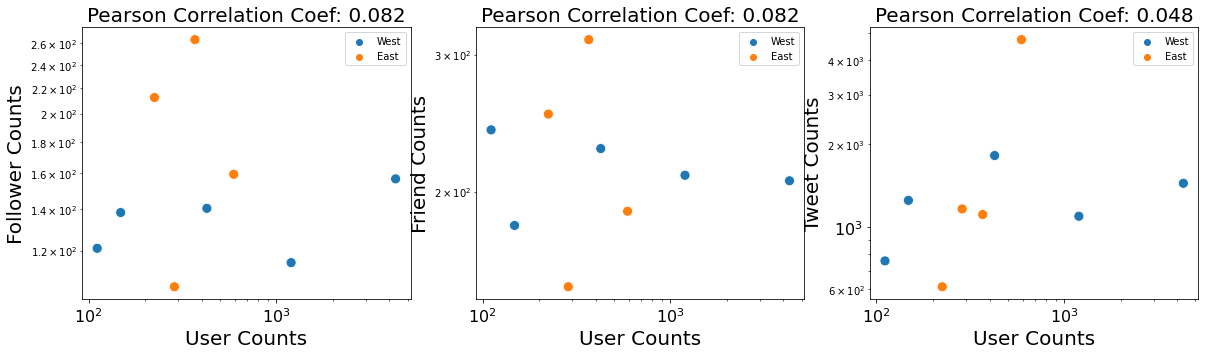

In [21]:
fig, ax = plt.subplots(1, 3, figsize = (20, 5))

ax[0].set(xscale="log", yscale='log')
sns.scatterplot(x = 'user_count', y = 'followers_count', hue=languages_stat.area.tolist(),
                data = languages_stat, ax = ax[0], s=100)
ax[0].set_xlabel('User Counts', fontsize = 20)
ax[0].set_ylabel('Follower Counts', fontsize = 20)
ax[0].set_title('Pearson Correlation Coef: 0.082', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)

ax[1].set(xscale="log", yscale='log')
sns.scatterplot(x = 'user_count', y = 'friends_count', hue=languages_stat.area.tolist(),
                data = languages_stat, ax = ax[1], s = 100)
ax[1].set_xlabel('User Counts', fontsize = 20)
ax[1].set_ylabel('Friend Counts', fontsize = 20)
ax[1].set_title('Pearson Correlation Coef: 0.082', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)

ax[2].set(xscale="log", yscale='log')
sns.scatterplot(x = 'user_count', y = 'statuses_count', hue=languages_stat.area.tolist(), 
                data = languages_stat, ax = ax[2], s=100)
ax[2].set_xlabel('User Counts', fontsize = 20)
ax[2].set_ylabel('Tweet Counts', fontsize = 20)
ax[2].set_title('Pearson Correlation Coef: 0.048', fontsize=20)
ax[2].xaxis.set_tick_params(labelsize=16)
ax[2].yaxis.set_tick_params(labelsize=16)

print(languages_stat['user_count'].corr(languages_stat['followers_count']))
print(languages_stat['user_count'].corr(languages_stat['friends_count']))
print(languages_stat['user_count'].corr(languages_stat['statuses_count']))

### Data Exploration for Cultures

To figure out whether the difference exists among western countries and eastern countries. We then group the users by the area, and check the distribution of each feature.

In [22]:
languages.groupby('area')[['followers_count', 'friends_count', 'statuses_count','avg_daily_tweets']].mean().reset_index()

area  followers_count  friends_count  statuses_count  avg_daily_tweets
0  East       183.017007     222.157823     2503.800000          3.508701
1  West       146.476267     208.564740     1383.686148          1.540678

In [23]:
languages.groupby('area')[['followers_count', 'friends_count', 'statuses_count','avg_daily_tweets']].median().reset_index()

area  followers_count  friends_count  statuses_count  avg_daily_tweets
0  East             46.0             88           119.0          0.313113
1  West             29.0             85            58.0          0.084555

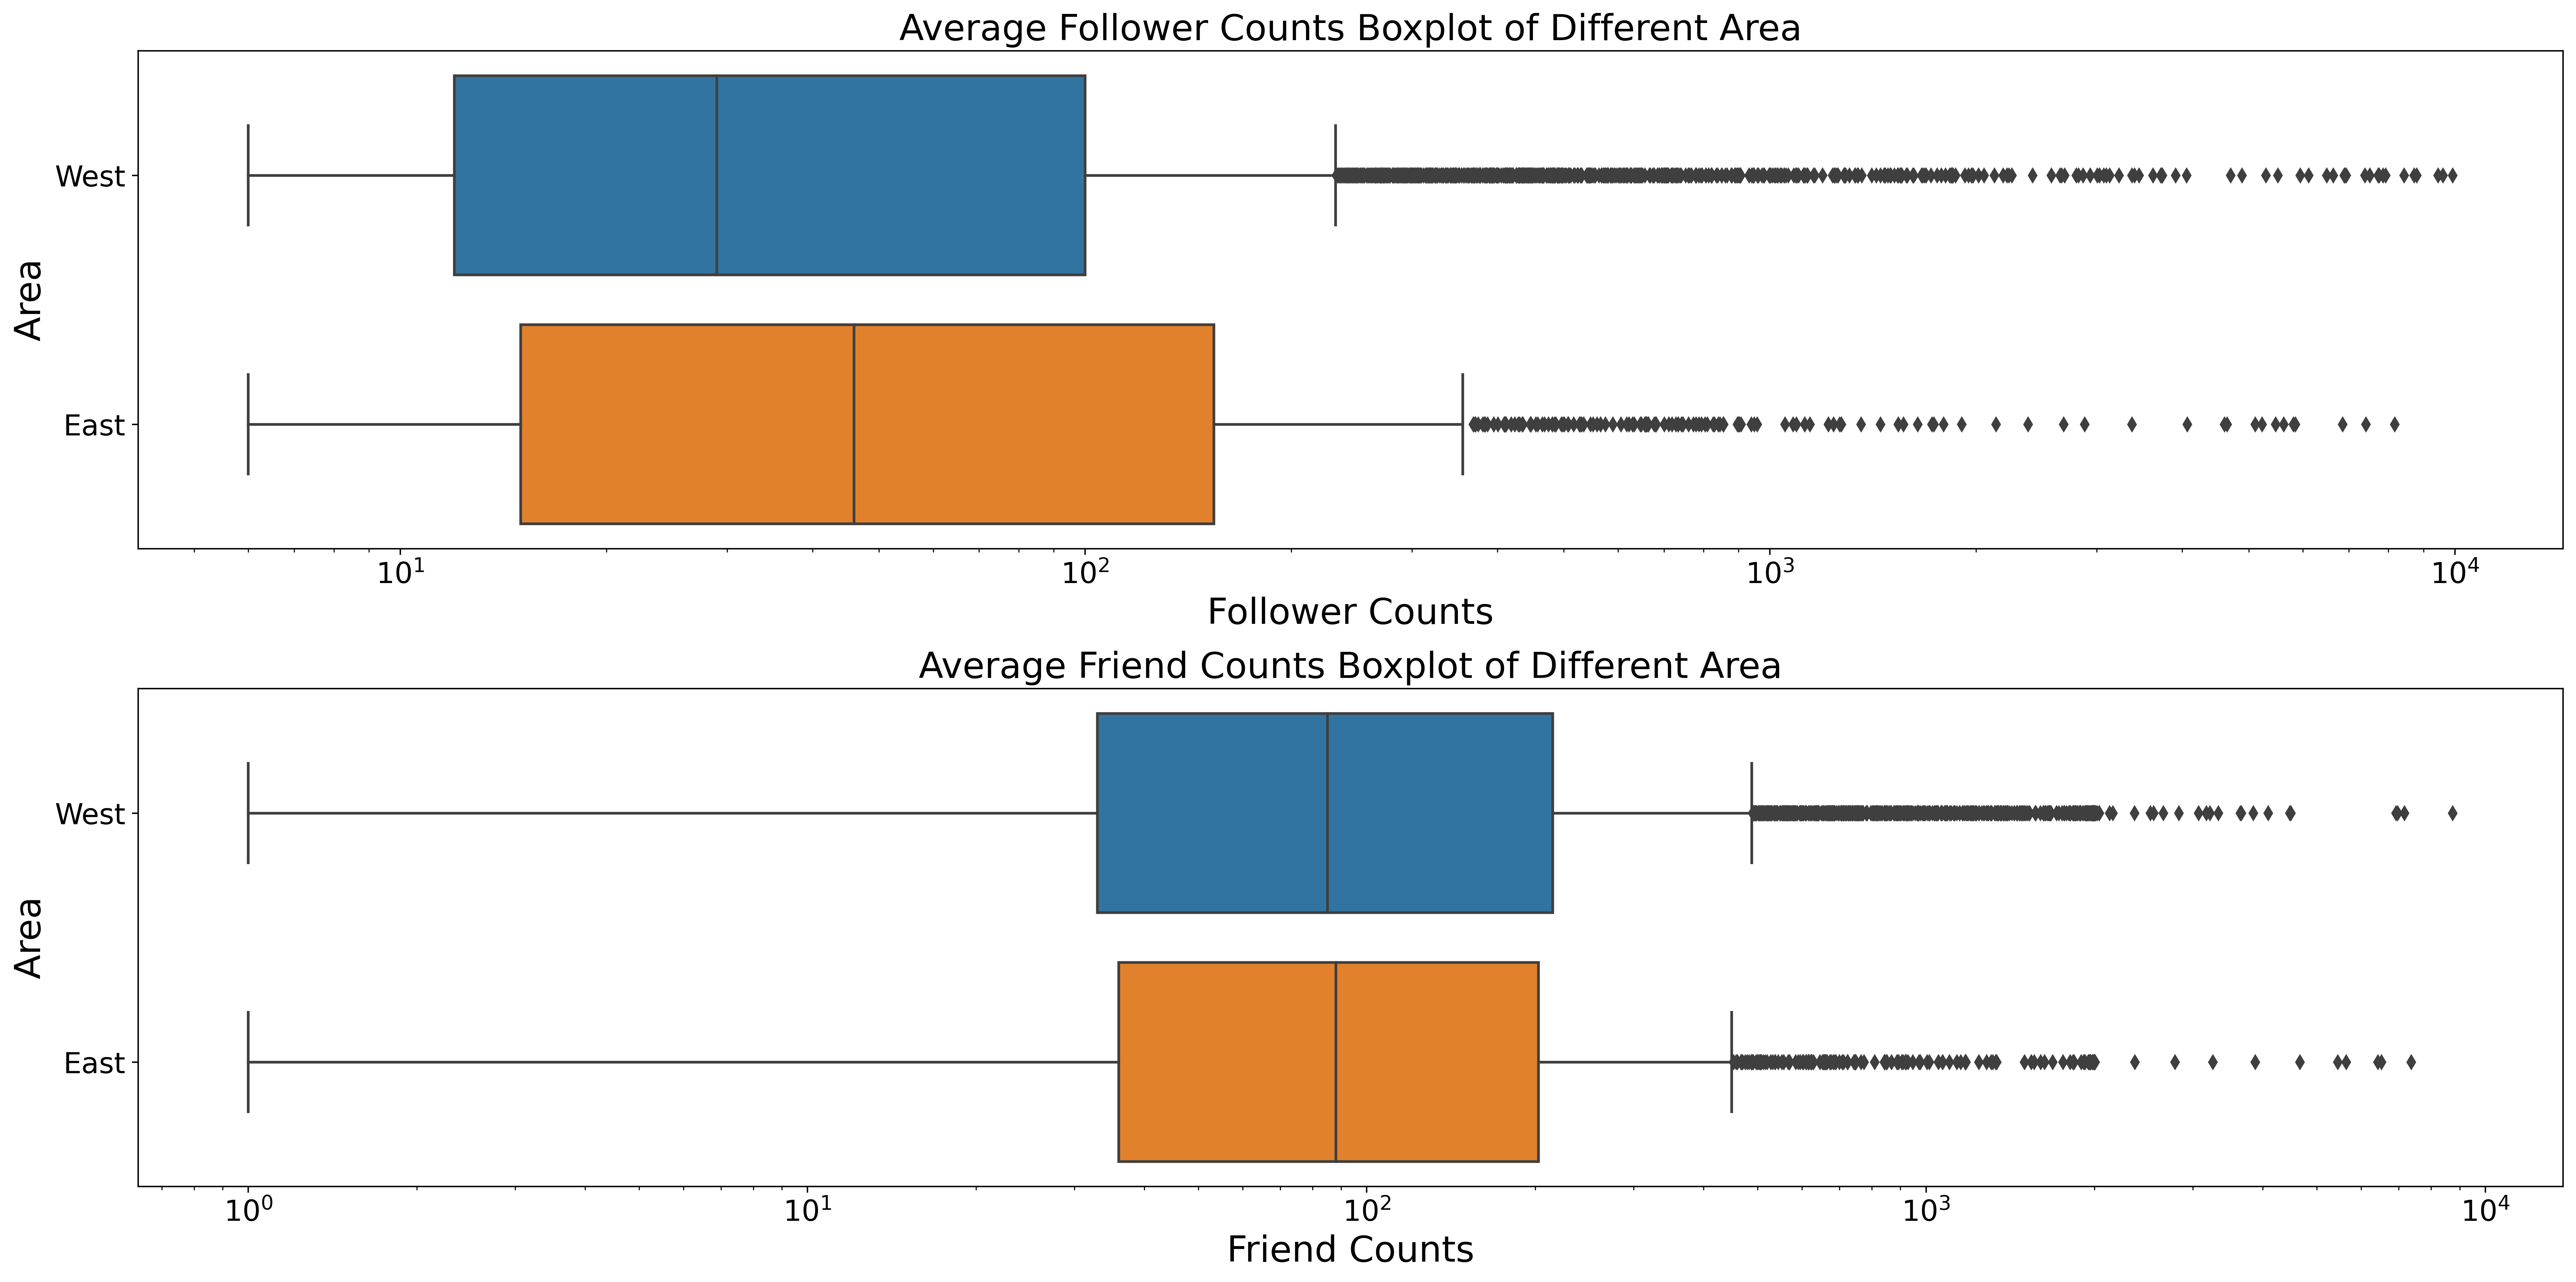

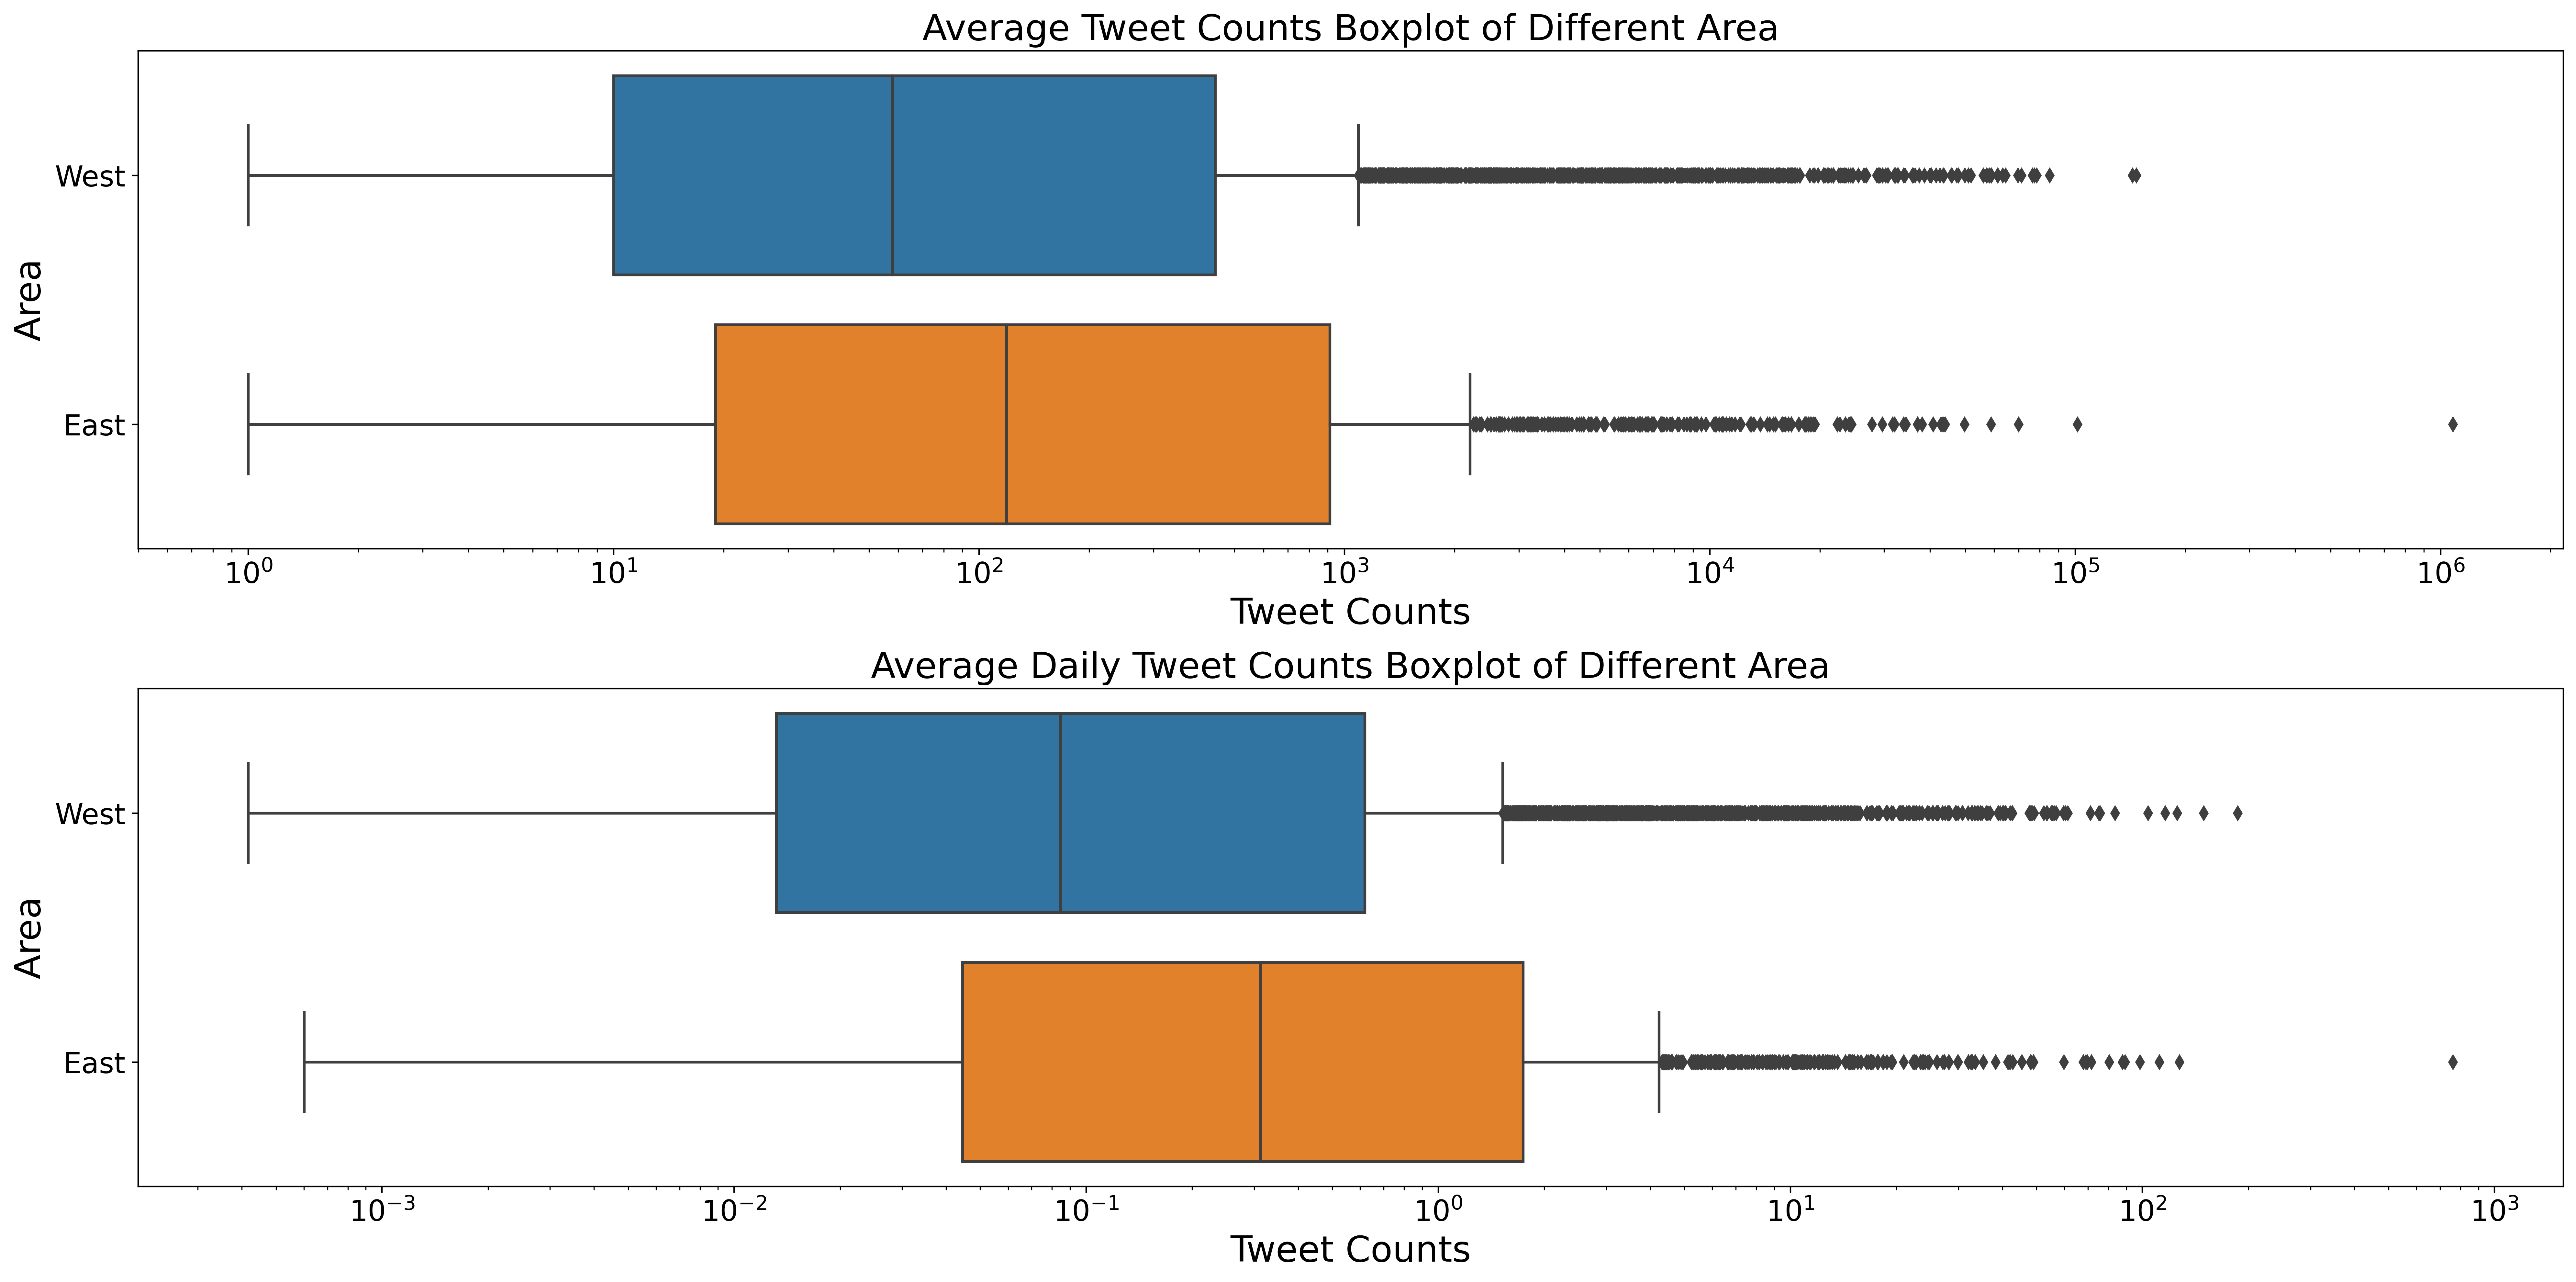

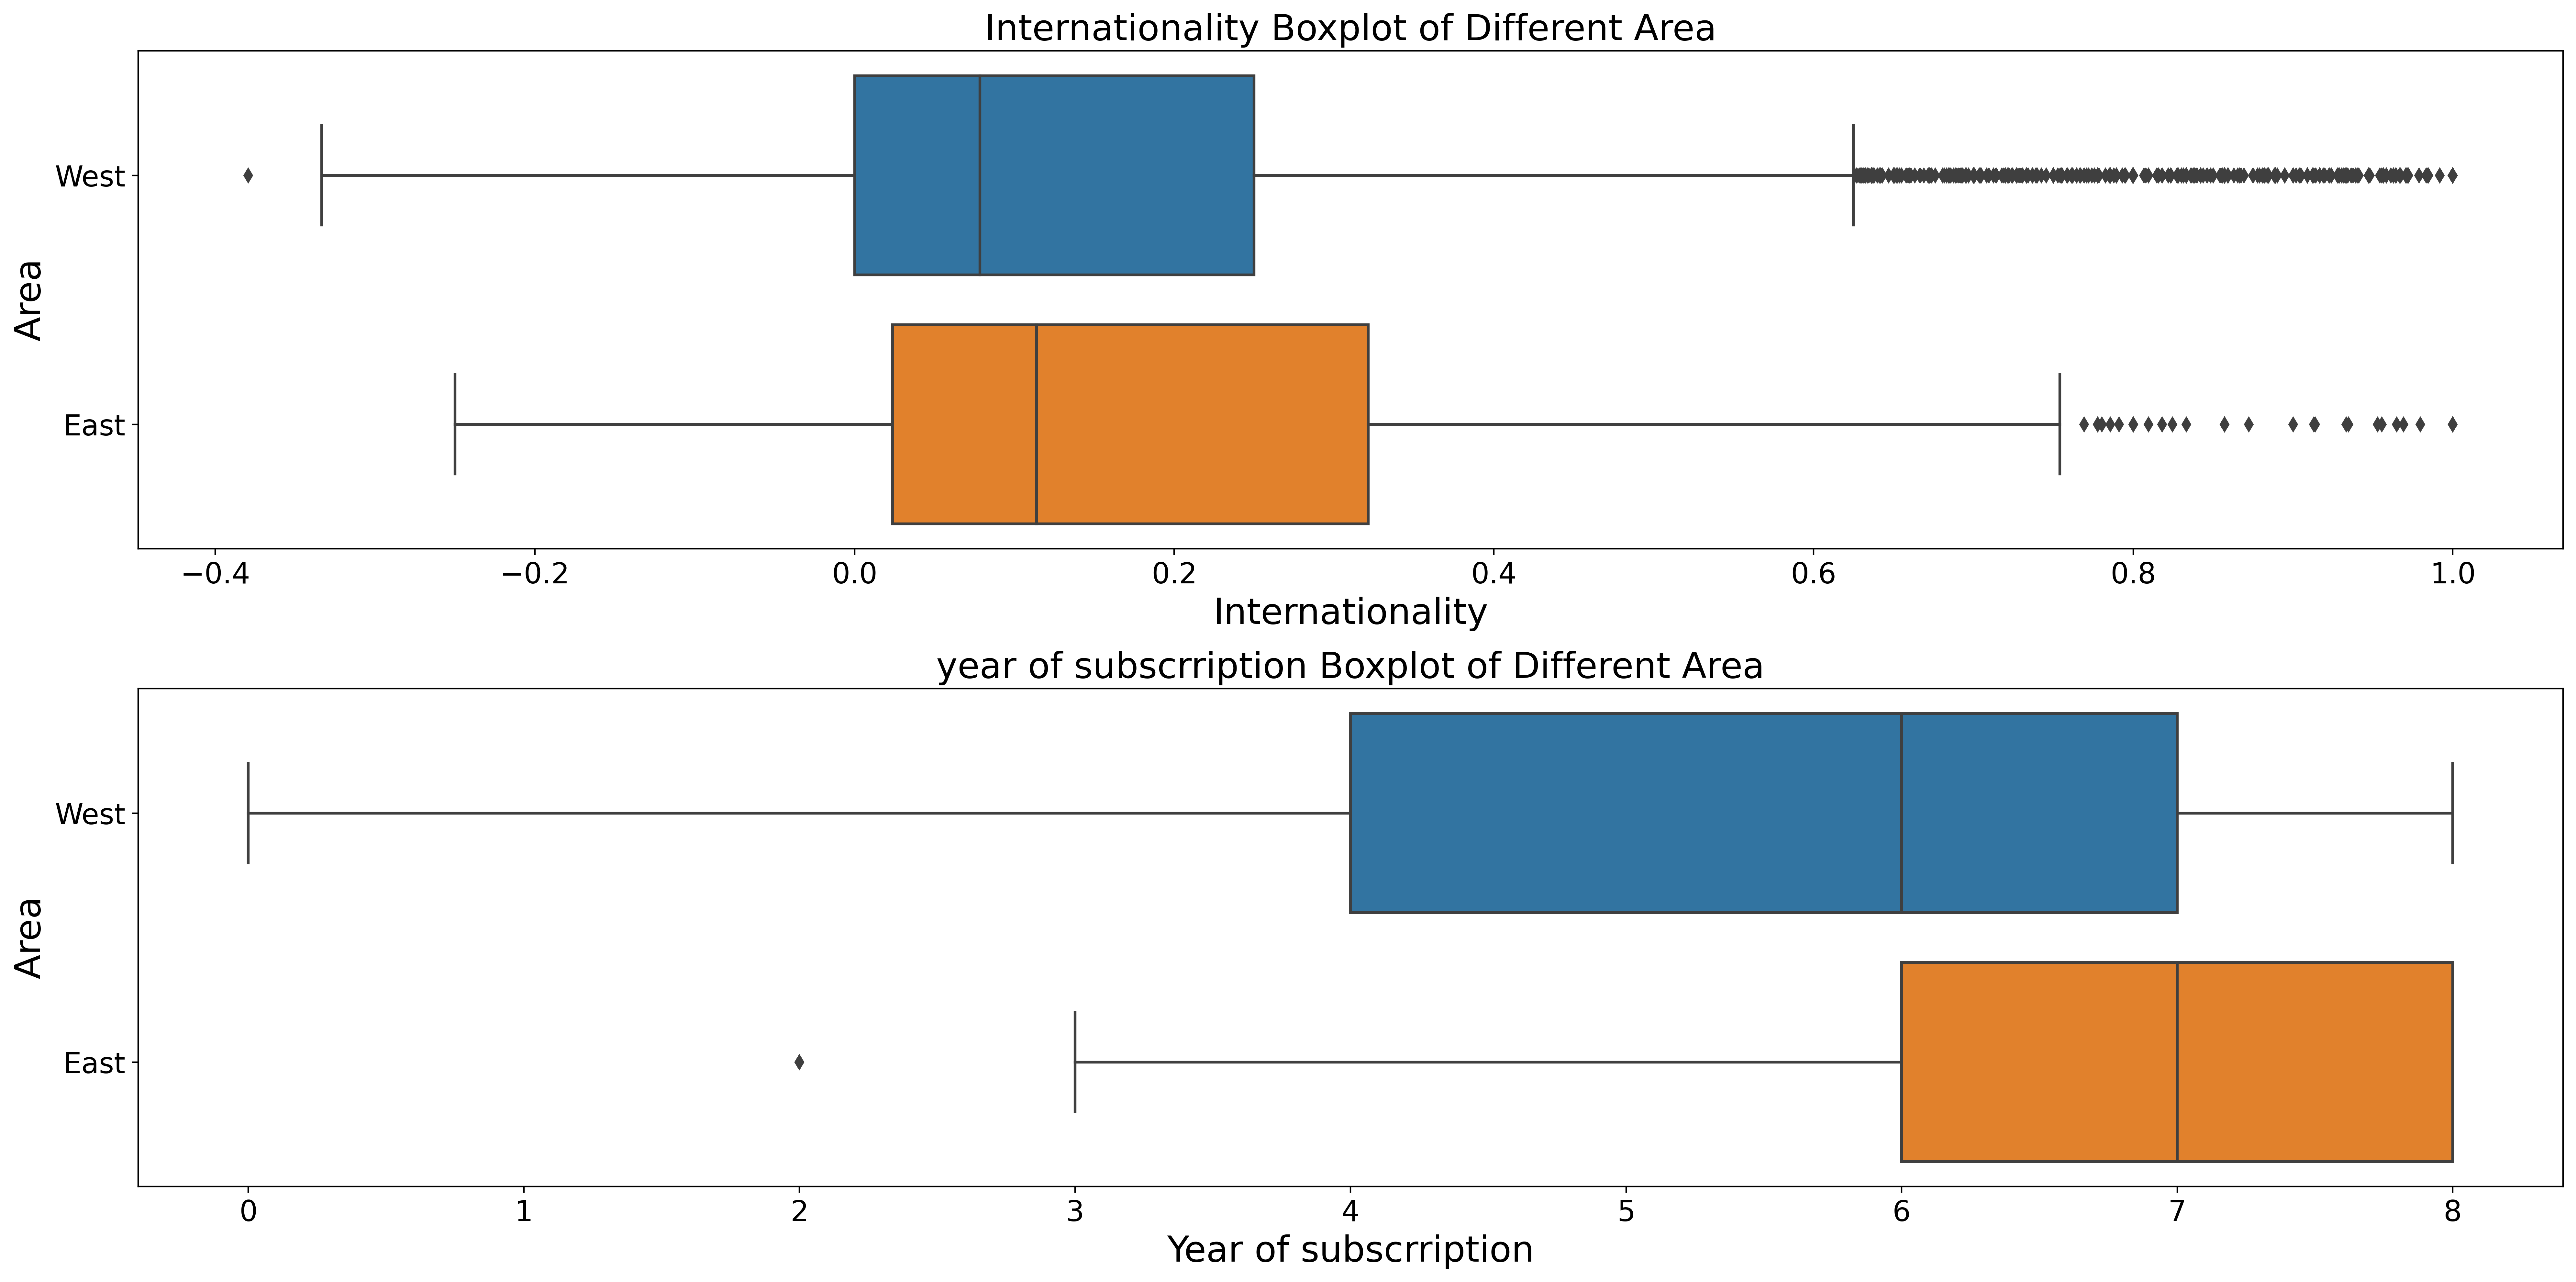

In [45]:
fig, ax = plt.subplots(2, 1, figsize = (20, 10), dpi = 400)

ax[0].set(xscale="log")
sns.boxplot( x = 'followers_count', y = 'area', data = languages, ax = ax[0])
ax[0].set_xlabel('Follower Counts', fontsize = 20)
ax[0].set_ylabel('Area', fontsize = 20)
ax[0].set_title('Average Follower Counts Boxplot of Different Area', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)

ax[1].set(xscale="log")
sns.boxplot( x = 'friends_count', y = 'area', data = languages, ax = ax[1])
ax[1].set_xlabel('Friend Counts', fontsize = 20)
ax[1].set_ylabel('Area', fontsize = 20)
ax[1].set_title('Average Friend Counts Boxplot of Different Area', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)

fig.tight_layout()
#plt.savefig("img/culture_popularity_boxplot.jpg")
plt.show()

fig, ax = plt.subplots(2, 1, figsize = (20, 10), dpi = 400)


ax[0].set(xscale="log")
sns.boxplot( x = 'statuses_count', y = 'area',  data = languages, ax = ax[0])
ax[0].set_xlabel('Tweet Counts', fontsize = 20)
ax[0].set_ylabel('Area', fontsize = 20)
ax[0].set_title('Average Tweet Counts Boxplot of Different Area', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)

ax[1].set(xscale="log")
sns.boxplot( x = 'avg_daily_tweets', y = 'area',  data = languages, ax = ax[1])
ax[1].set_xlabel('Tweet Counts', fontsize = 20)
ax[1].set_ylabel('Area', fontsize = 20)
ax[1].set_title('Average Daily Tweet Counts Boxplot of Different Area', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)

fig.tight_layout()
#plt.savefig("img/culture_activeness_boxplot.jpg")
plt.show()

fig.tight_layout()
#plt.savefig("img/culture_popularity_boxplot.jpg")
plt.show()


fig, ax = plt.subplots(2, 1, figsize = (20, 10), dpi = 400)


#ax[0].set(xscale="log")
sns.boxplot( x = 'Internationality', y = 'area',  data = languages, ax = ax[0])
ax[0].set_xlabel('Internationality', fontsize = 20)
ax[0].set_ylabel('Area', fontsize = 20)
ax[0].set_title('Internationality Boxplot of Different Area', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)

#ax[1].set(xscale="log")
sns.boxplot( x = 'year', y = 'area',  data = languages, ax = ax[1])
ax[1].set_xlabel('Year of subscrription', fontsize = 20)
ax[1].set_ylabel('Area', fontsize = 20)
ax[1].set_title('year of subscrription Boxplot of Different Area', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)

fig.tight_layout()
#plt.savefig("img/culture_activeness_boxplot.jpg")
plt.show()

There is a more even distribution of followers, friends and tweets in the eastern culture compared to the western culture. 
A larger proportion of counts belong to the top 25% users in the western culture, implying dominance by some famous users. 

For the number of tweets, there is a single point with surprisingly high number of tweets which is very apparent in the boxplot

In [25]:
languages_east = languages[languages['area'] == 'East']
languages_west = languages[languages['area'] == 'West']

a = languages_east['followers_count'].tolist()
b = languages_west['followers_count'].tolist()
#print(stats.kstest(a, b))
print(stats.ttest_ind(a, b))

a = languages_east['friends_count'].tolist()
b = languages_west['friends_count'].tolist()
#print(stats.kstest(a, b))
print(stats.ttest_ind(a, b))

a = languages_east['statuses_count'].tolist()
b = languages_west['statuses_count'].tolist()
#print(stats.kstest(a, b))
print(stats.ttest_ind(a, b))

a = languages_east['statuses_count'].tolist()
b = languages_west['statuses_count'].tolist()
#print(stats.kstest(a, b))
print(stats.ttest_ind(a, b))

Ttest_indResult(statistic=2.3237050663543766, pvalue=0.020167335334062546)
Ttest_indResult(statistic=1.1070055230960834, pvalue=0.26832629301219013)
Ttest_indResult(statistic=2.8301863384387165, pvalue=0.004664196400429606)
Ttest_indResult(statistic=2.8301863384387165, pvalue=0.004664196400429606)


### Case Study for different cultures

To delve deeper into the difference between eastern contries and western countries, we then try to reproduce some figures in the paper but group it by different cultures.

##### 1. Distribution of the number of tweets per user

Figures show the distribution of eastern countries and western countries are almost the same.

In [26]:
user_profiles = pd.read_csv(R'Data/EgoAlterProfiles.txt', sep = '\t')

In [27]:
user_profiles = user_profiles[user_profiles['IsEgo'] == True]
user_profiles['lang'] = user_profiles['lang'].str.lower()

In [28]:
western_language = ['bg', 'ca', 'cs', 'da', 'de', 'el', 'en', 'en-au', 'en-gb', 'es', 'es-mx', 'eu', 'fa',
                 'fi',  'fr', 'he', 'hi', 'hr', 'hu',   'it', 'ka', 'lv', 'nb', 'nl', 'no', 'pl', 'pt',
                 'pt-pt', 'ro', 'ru', 'sr', 'sv', 'uk']

eastern_langauge = ['ar', 'az', 'fil', 'id', 'in', 'ja', 'ko', 'ms', 'msa', 'th', 'tr', 'vi' , 'zh', 'zh-cn',
                    'zh-hans', 'zh-hant', 'zh-tw']

In [29]:
# filter the ego user and sort it by 'statuses_count'
ego = user_profiles[user_profiles['IsEgo'] == True]
ego_west = user_profiles[user_profiles['lang'].isin(western_language)]
ego_west = ego_west.sort_values(by = ['statuses_count'], ascending = False).reset_index(drop=True)

ego_east = user_profiles[user_profiles['lang'].isin(eastern_language)]
ego_east = ego_east.sort_values(by = ['statuses_count'], ascending = False).reset_index(drop=True)

# check the number of egos and the data
#print(ego_west.shape)
#ego_west.head()

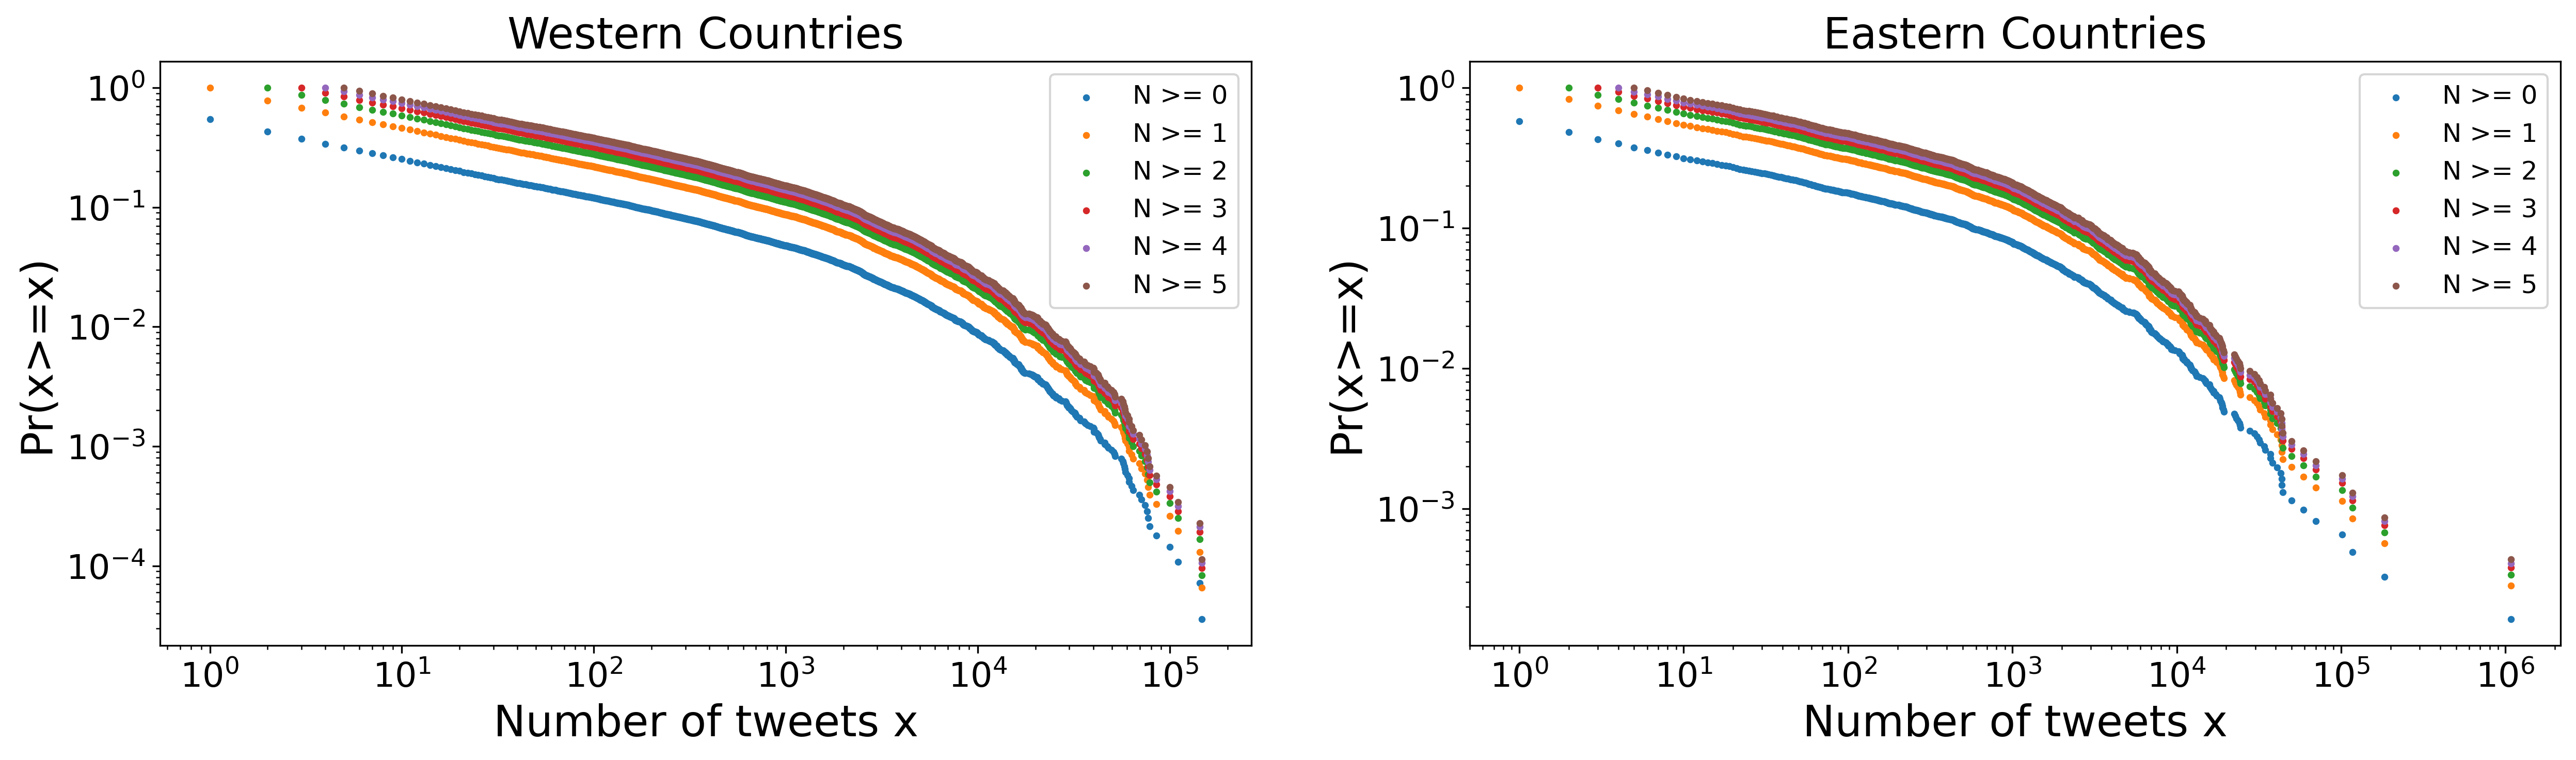

In [30]:
# prepare for the plot

fig, ax = plt.subplots(1, 2, figsize = (20, 5), dpi = 300)

# western plot

ax[0].set_title('Western Countries', fontsize = 20)
ax[0].set_xlabel('Number of tweets x', fontsize=20)
ax[0].set_ylabel('Pr(x>=x)', fontsize=20)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)

# calculate the number of people for each tweet counts 
temp = ego_west.groupby(ego_west['statuses_count']).count()['ID']
temp = temp.sort_index(ascending = False)

# loop the threshold from 0 to 5
for N in range(0, 6):
    temp = temp[temp.index >= N]
    tweet = temp.index.to_list()
    count = temp.to_list()
    total = np.sum(count)
    
    # cumulate tweet counts
    for i in range(1, len(tweet)):
        count[i]+=count[i-1]
    
    # calculate the ccdf for x (divide cumulated tweet counts by total number of tweets)
    for i in range(len(tweet)):
        count[i]/=total
    
    ax[0].scatter(tweet, count, s = 5, label = 'N >= {}'.format(N))

ax[0].legend(title="", fontsize=12, title_fontsize=12, loc = 1)

# eastern plot

ax[1].set_title('Eastern Countries', fontsize = 20)
ax[1].set_xlabel('Number of tweets x', fontsize=20)
ax[1].set_ylabel('Pr(x>=x)', fontsize=20)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)

# calculate the number of people for each tweet counts 
temp = ego_east.groupby(ego_east['statuses_count']).count()['ID']
temp = temp.sort_index(ascending = False)

# loop the threshold from 0 to 5
for N in range(0, 6):
    temp = temp[temp.index >= N]
    tweet = temp.index.to_list()
    count = temp.to_list()
    total = np.sum(count)
    
    # cumulate tweet counts
    for i in range(1, len(tweet)):
        count[i]+=count[i-1]
    
    # calculate the ccdf for x (divide cumulated tweet counts by total number of tweets)
    for i in range(len(tweet)):
        count[i]/=total
    
    ax[1].scatter(tweet, count, s = 5, label = 'N >= {}'.format(N))

ax[1].legend(title="", fontsize=12, title_fontsize=12, loc = 1)

#plt.savefig("img/tweets_per_user_distribution.jpg")
plt.show()

The distribution of number of tweets per user is quite similar for both. And the law of 80-20% is still plausible. 

##### 2. Daily and Weekly Rhythms of Twitter Activity

In [31]:
ego_timeline = pd.read_csv(R'Data/EgoTimelines.txt', sep = '\t', encoding='latin-1')

Create a new column to save the time as a datetime object.

In [32]:
from datetime import datetime, timedelta

def convert_time(s: str):
    '''
    convert twitter time string format to a datetime object
    '''
    new_time = datetime.strptime(s, '%a %b %d %H:%M:%S %z %Y')
    return new_time

ego_timeline['time'] = ego_timeline['created_at'].astype('str').apply(convert_time)

Calibrate the time by utc offset.

In [33]:
# create a dictionary to map egoID to utc offset
ego['utc_offset'] = ego['utc_offset'].fillna(0)
offset = dict(zip(ego['ID'], ego['utc_offset']))

def get_offset(ID):
    '''
    obtain the utc offset from the dictionary by ID
    '''
    return offset[ID]

def convert_to_timedelta(s):
    '''
    convert float to timedelta datatype
    '''
    return timedelta(seconds = s)

# create a new column which represents the required offset
ego_timeline['utc_offset'] = ego_timeline['egoID'].apply(get_offset)

# add the offset to the time column
ego_timeline['time'] = ego_timeline['time'] + ego_timeline['utc_offset'].apply(convert_to_timedelta)

Extract week day and hour from the time column for later usage

In [34]:
def get_week_day(dt):
    return dt.strftime('%a')

def get_time(dt):
    return int(dt.strftime("%H"))

ego_timeline['week_day'] = ego_timeline['time'].apply(get_week_day)
ego_timeline['hour'] = ego_timeline['time'].apply(get_time)

#ego_timeline.head()

Create two new dataframe for tweet counts and active user counts.

In [35]:
ego_lang = dict(zip(ego['ID'], ego['lang'].isin(western_language)))

def add_area(id):
    if ego_lang[id]:
        return 'west'
    else:
        return 'east'

ego_timeline['area'] = ego_timeline['egoID'].apply(add_area)
ego_timeline_west = ego_timeline[ego_timeline['area'] == 'west']
ego_timeline_east = ego_timeline[ego_timeline['area'] == 'east']

In [36]:
tweet_time_west = ego_timeline_west.groupby( [ 'week_day', 'hour'] ).size().reset_index(name = 'count')
user_time_west = ego_timeline_west.groupby( [ 'week_day', 'hour'] )['egoID'].nunique().reset_index(name = 'count')
tweet_time_east = ego_timeline_east.groupby( [ 'week_day', 'hour'] ).size().reset_index(name = 'count')
user_time_east = ego_timeline_east.groupby( [ 'week_day', 'hour'] )['egoID'].nunique().reset_index(name = 'count')

Plot the figure.

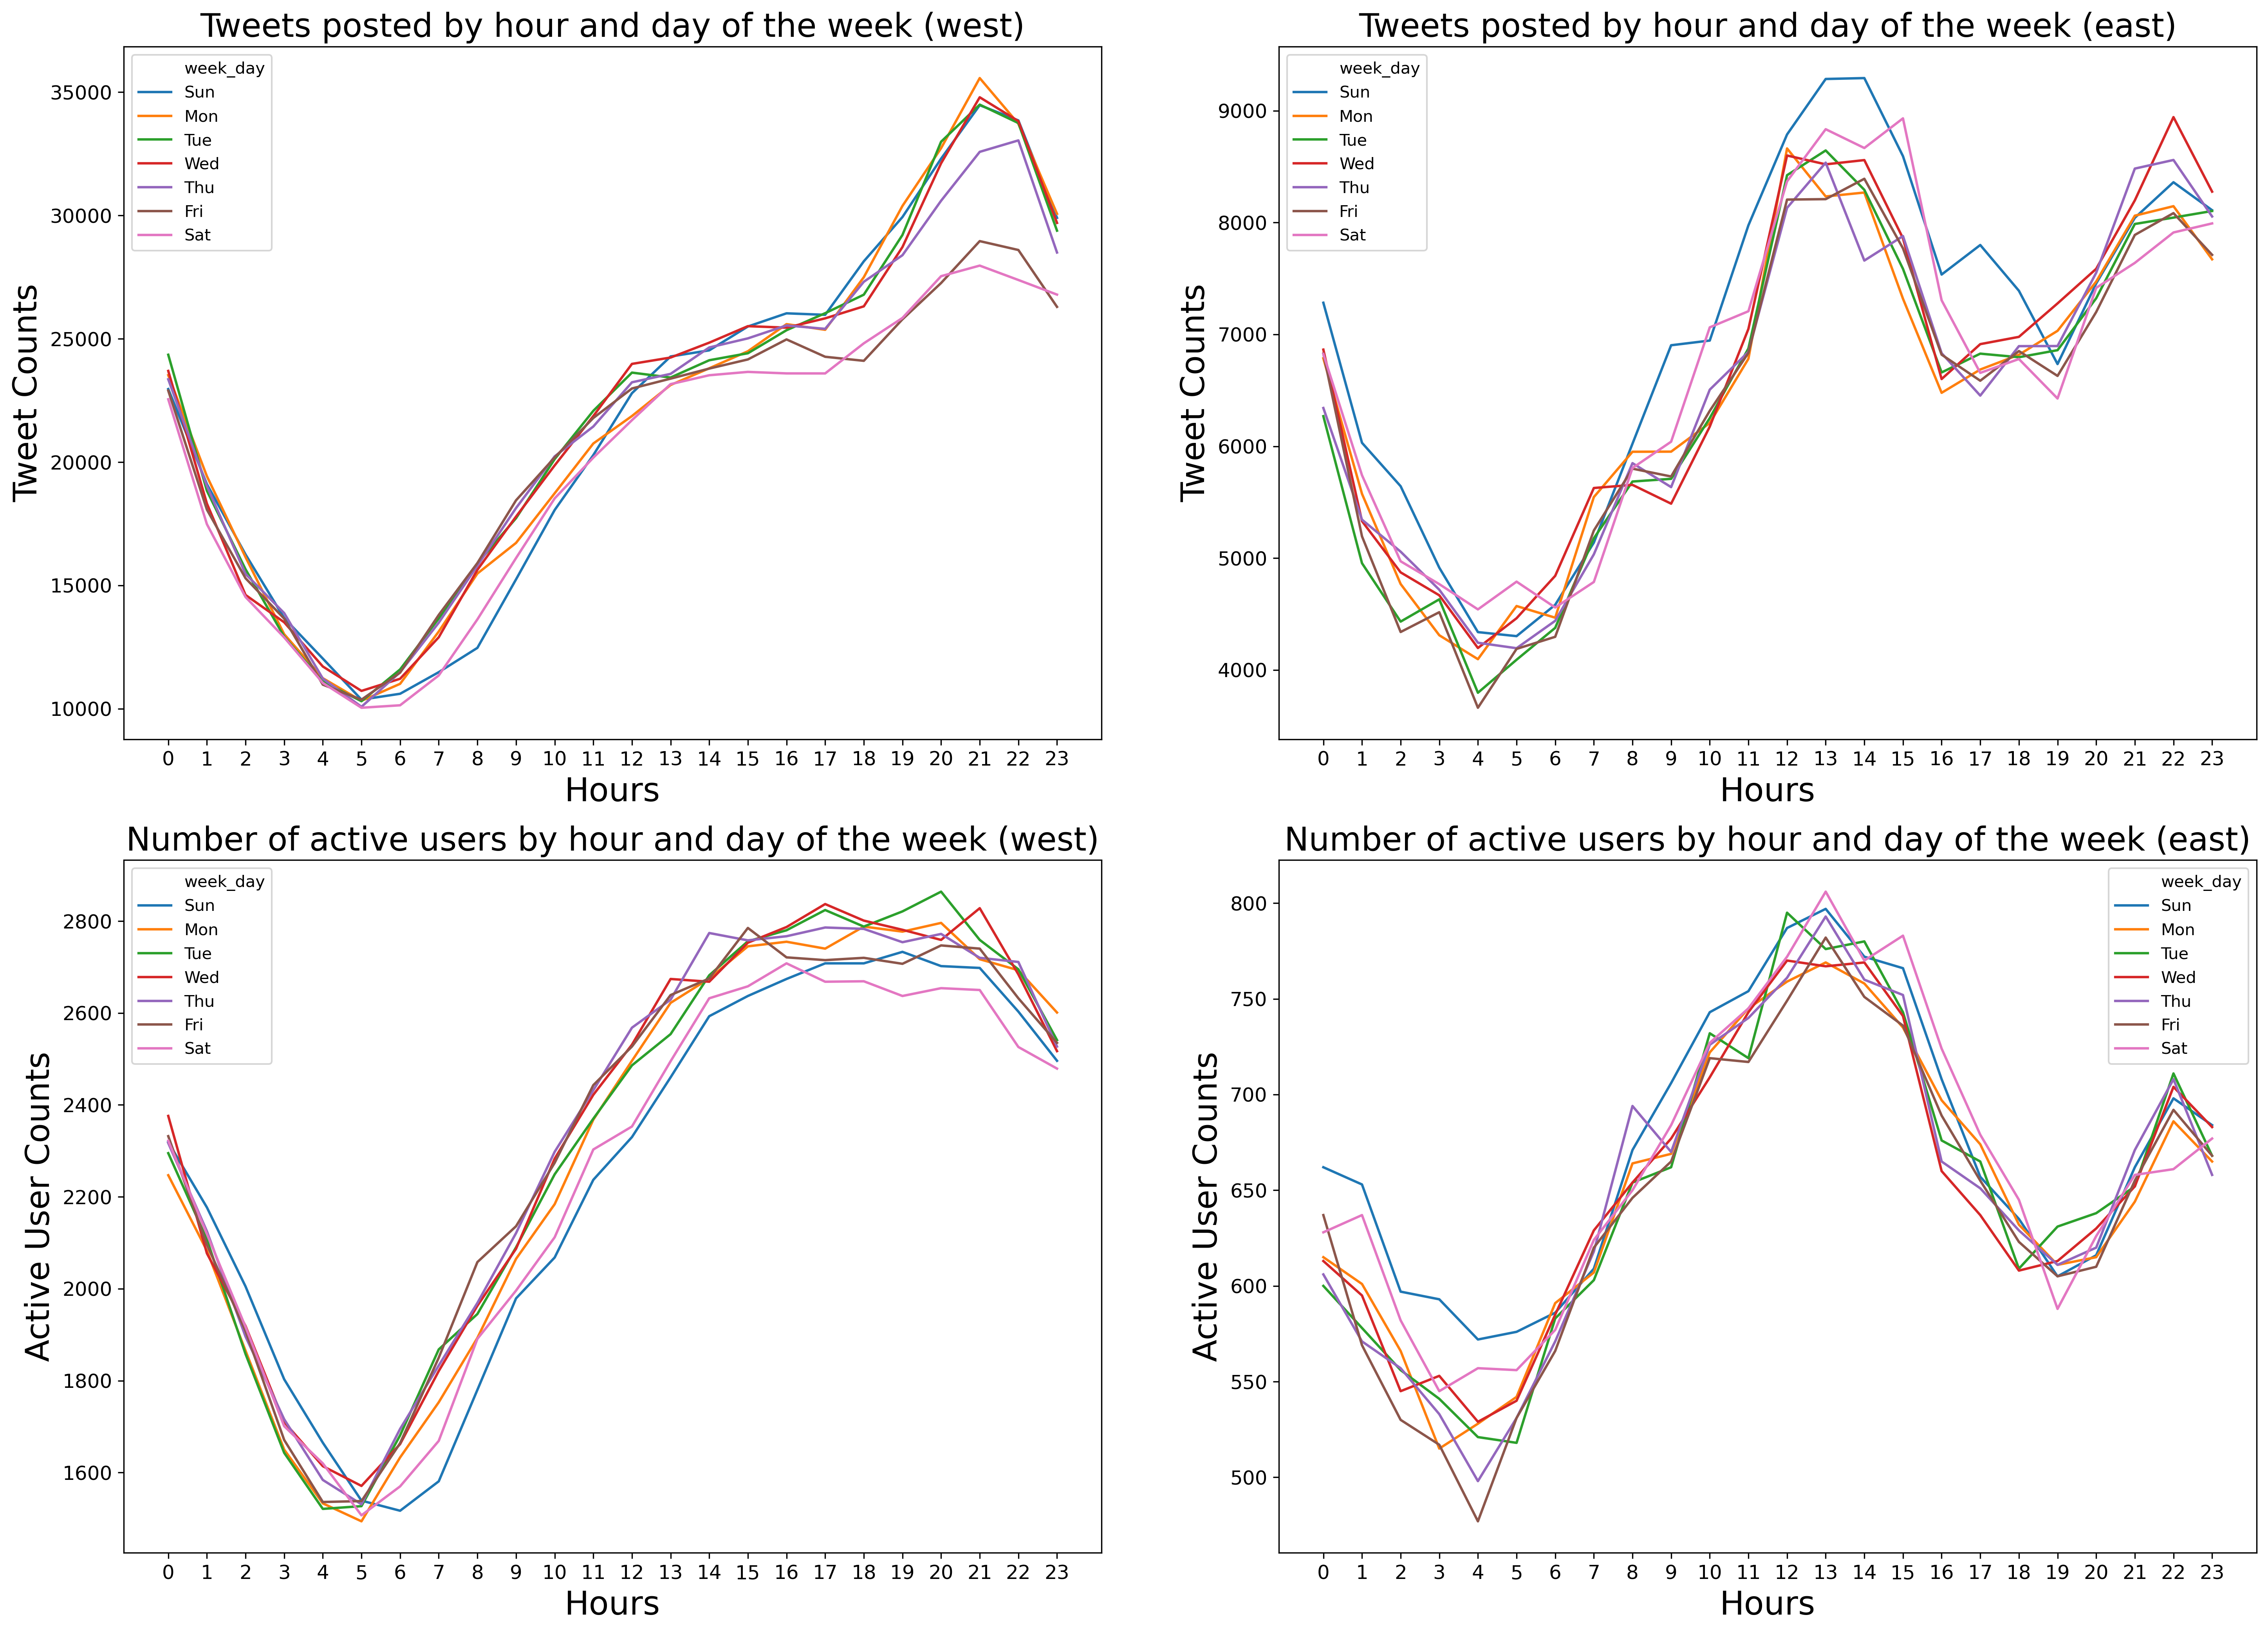

In [37]:
fig, ax = plt.subplots(2, 2, figsize = (20, 14), dpi=300)

sns.lineplot(data = tweet_time_west, x = 'hour', y = 'count', hue = 'week_day', ax = ax[0,0],
             hue_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax[0,0].set_xlabel('Hours', fontsize=20)
ax[0,0].set_ylabel('Tweet Counts', fontsize=20)
ax[0,0].set_xticks(np.arange(0, 24))
ax[0,0].set_title('Tweets posted by hour and day of the week (west)', fontsize=20)
ax[0,0].xaxis.set_tick_params(labelsize=12)
ax[0,0].yaxis.set_tick_params(labelsize=12)

sns.lineplot(data = user_time_west, x = 'hour', y = 'count', hue = 'week_day', ax = ax[1,0],
            hue_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax[1,0].set_xlabel('Hours', fontsize=20)
ax[1,0].set_ylabel('Active User Counts', fontsize=20)
ax[1,0].set_xticks(np.arange(0, 24))
ax[1,0].set_title('Number of active users by hour and day of the week (west)', fontsize=20)
ax[1,0].xaxis.set_tick_params(labelsize=12)
ax[1,0].yaxis.set_tick_params(labelsize=12)


sns.lineplot(data = tweet_time_east, x = 'hour', y = 'count', hue = 'week_day', ax = ax[0,1],
             hue_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax[0,1].set_xlabel('Hours', fontsize=20)
ax[0,1].set_ylabel('Tweet Counts', fontsize=20)
ax[0,1].set_xticks(np.arange(0, 24))
ax[0,1].set_title('Tweets posted by hour and day of the week (east)', fontsize=20)
ax[0,1].xaxis.set_tick_params(labelsize=12)
ax[0,1].yaxis.set_tick_params(labelsize=12)

sns.lineplot(data = user_time_east, x = 'hour', y = 'count', hue = 'week_day', ax = ax[1,1],
            hue_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax[1,1].set_xlabel('Hours', fontsize=20)
ax[1,1].set_ylabel('Active User Counts', fontsize=20)
ax[1,1].set_xticks(np.arange(0, 24))
ax[1,1].set_title('Number of active users by hour and day of the week (east)', fontsize=20)
ax[1,1].xaxis.set_tick_params(labelsize=12)
ax[1,1].yaxis.set_tick_params(labelsize=12)

plt.tight_layout()
#plt.savefig("img/active_time.jpg")
plt.show()

The plot for the eastern and western cultures look quite different. But they still seem to follow the circadian rythm pattern as suggested in the paper. 

But an interesting thing to note is that a peak in the number of tweets is visible around 22h for both west and east, but there is an equally high peak in the number of tweets around 13h in the east. Also, the number of active users gradually increase after 4h for both west and east. But there is a drastic dip in the number of active users between 15h and 21h in the east. The number of tweets is also less during this time in the east (Maybe this is what makes a peak at 13h visible, and there is no reason for peak at 13h but there is a reason for inactivity from 15h to 21h) --What could be the reason for this?

Also, not the difference in scales. 35k vs 9k tweets per day. 2800 vs 800 active users per day. West vs East. 

### Following Preference Analysis

In [38]:
ego_network = pd.read_csv(r"Data/EgoNetworks.txt", sep = '\t')
ego_alter_profiles = pd.read_csv(r"Data/EgoAlterProfiles.txt", sep = '\t')

In [39]:
ego_alter_list = languages_with_alter['ID'].tolist()

#ego_network = ego_network[(ego_network['followerID'].isin(ego_alter_list)) 
#                          | (ego_network['followeeID'].isin(ego_alter_list))]

#only consider ego as follower
ego_network = ego_network[(ego_network['followerID'].isin(ego_alter_list))]

ego_network.head()

egoID  followerID  followeeID
0      1           1     1573741
1      1           1     1662720
2      1           1     1968904
3      1           1     1970142
4      1           1     1970507

In [40]:
mapping_id_language = dict(zip(ego_alter_profiles['ID'], ego_alter_profiles['lang']))

def assign_lang(id):
    return mapping_id_language[id]

ego_network['lang1'] = ego_network['followerID'].apply(assign_lang)
ego_network['lang2'] = ego_network['followeeID'].apply(assign_lang)
ego_network['same_lang'] = np.where(ego_network['lang1'] == ego_network['lang2'], True, False)
ego_network['same_lang'].value_counts()

True     1268642
False     345138
Name: same_lang, dtype: int64

In [41]:
language_order = languages_stat.index.tolist()
print(language_order)
mapping_language = dict(zip(language_order, [i for i in range(0, 12)]))

rows, cols = (12, 12) 
connection = [[0 for i in range(cols)] for j in range(rows)] 
follow_pair = list(zip(ego_network['lang1'], ego_network['lang2']))

for i, v in enumerate(follow_pair):
    if follow_pair[i][0] in language_order and follow_pair[i][1] in language_order:
        connection[mapping_language[follow_pair[i][0]]][mapping_language[follow_pair[i][1]]] += 1

connection_dataframe = pd.DataFrame(connection, columns = language_order, index = language_order)  
connection_dataframe.head(12)

['ru', 'fr', 'tr', 'id', 'ar', 'pt', 'ja', 'es', 'en']


ValueError: 9 columns passed, passed data had 12 columns

In [ ]:
languages_stat

In [ ]:
for i in range(12):
    fig, ax = plt.subplots(figsize = (20, 7), dpi = 300)
    ax.set(yscale = 'log')
    splot = sns.barplot(x = languages_stat.index, y = connection[i], hue = languages_stat['area'].tolist(),
                        ax = ax, dodge = False)
    ax.set_xlabel('Language', fontsize = 20)
    ax.set_ylabel('Following Counts', fontsize = 20)
    ax.set_title('Total following counts of {} users'.format(languages_stat.index[i]), fontsize=20)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    if i >= 2:
        ax.legend(title="Area", fontsize=16, title_fontsize=16, loc = 2)
    else:
        ax.legend(title="Area", fontsize=16, title_fontsize=16, loc = 0)
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontsize = 12) 
    #fig.savefig('img/language_following/language_following_counts_{}.jpg'.format(languages_stat.index[i]))

# Supervised Learning
# Classification of the culture

#### Split the dataset

In [70]:
dataset = languages.drop(columns = ['ID', 'IsEgo', 'lang'])

dataset['area'] = dataset['area'].apply(lambda x: 1 if x=='West' else 0)

train = dataset.sample(frac=0.7,random_state=200)
test = dataset.drop(train.index)

X_train = train.loc[:, train.columns != 'area']
y_train = train['area']
X_test = test.loc[:, test.columns != 'area']
y_test = test['area']

X_train

followers_count  friends_count  statuses_count  Internationality  \
2988             26.0             34            35.0          0.000000   
5032             24.0             36             2.0          0.000000   
4896             11.0             30            40.0          0.181818   
6486             80.0            125           802.0          0.000000   
4893             90.0             99           107.0          0.022222   
...               ...            ...             ...               ...   
7230             50.0            115            58.0          0.040000   
6914             10.0             29            25.0          0.100000   
306              33.0             87           376.0          0.060606   
5610            401.0            456          1191.0          0.109726   
2746             46.0            422           367.0          0.000000   

      avg_daily_tweets  year  
2988          0.020000     4  
5032          0.004819     7  
4896          0.068966     7  
6486          1.098630     6  
4893          0.237778     7  
...                ...   ...  
7230          0.065984     6  
6914          0.044803     7  
306           0.321642     5  
5610          1.399530     6  
2746          0.183500     3  

[5365 rows x 6 columns]

#### Preprocessing

In [71]:
from sklearn import preprocessing
import statsmodels.api as sm

# Polynomial feature expansion
#poly = preprocessing.PolynomialFeatures(2, include_bias=False)
#X_train = poly.fit_transform(X_train)
#X_test = poly.fit_transform(X_test)

# scalarization
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# intercept
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

### Logistic Model

In [52]:
logit_mod = sm.Logit(y_train, X_train)
logit_res = logit_mod.fit()

print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.452177
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   area   No. Observations:                 5365
Model:                          Logit   Df Residuals:                     5358
Method:                           MLE   Df Model:                            6
Date:                Wed, 16 Dec 2020   Pseudo R-squ.:                 0.07547
Time:                        13:38:31   Log-Likelihood:                -2425.9
converged:                       True   LL-Null:                       -2624.0
Covariance Type:            nonrobust   LLR p-value:                 1.959e-82
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6034      0.040     40.014      0.000       1.525       1.682
x1            -0.0479      0.

As expected there are regressors more significant then others. In particular there is not strong statical evidence to say that the number of followers ($t-student=-1.091$, $p-value=0.275$) and friends ($t-student=1,003$, $p-value=0.316$) are significant regrossor to predict Western or Eastern culture of a user. Also the number of daily tweets ($t-student=-1.157$, $p-value=0.247$) is not not a significant regressor, but maybe because it is strong correlated with the total number of tweets published and the year of subscription.

In [53]:
from sklearn.metrics import accuracy_score

y_pred = np.around(logit_res.predict(X_train))
print('Accuracy Train: ', accuracy_score(y_train, y_pred))

y_pred = np.around(logit_res.predict(X_test))
print('Accuracy Test: ',accuracy_score(y_test, y_pred))

Accuracy Train:  0.8078285181733458
Accuracy Test:  0.807742496737712


### Random Forest

In [68]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 500, random_state = 42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

In [69]:
from sklearn.metrics import accuracy_score

y_pred = np.around(rf.predict(X_train))
print('Accuracy Train: ', accuracy_score(y_train, y_pred))

y_pred = np.around(rf.predict(X_test))
print('Accuracy Test: ',accuracy_score(y_test, y_pred))

Accuracy Train:  1.0
Accuracy Test:  0.8116572422792518


# Usupervised Learning

I would like to get the same cluster of the culture

In [ ]:
# Load the ego networks as DataFrame
ego_networks = pd.read_csv("Data/EgoNetworks.txt", sep = '\t')

print(ego_networks)

# Filter out rows with egoID, followerID and followeeID which do not have language information
ego_networks_lang = ego_networks[(ego_networks['egoID'].isin(languages['ID'])) & 
                                (ego_networks['followerID'].isin(languages['ID'])) & 
                                (ego_networks['followeeID'].isin(languages['ID']))]

# Ignore SettingWithCopyWarning - reference: https://www.dataquest.io/blog/settingwithcopywarning/
pd.set_option('mode.chained_assignment', None)

# Create dictionary mapping between users and their languages 
user_lang = dict(zip(languages['ID'], languages['lang']))

# Function to return user language from ID
def get_lang(ID):
    return user_lang[ID]

# Add new column with user languages for followers
ego_networks_lang['follower_lang'] = ego_networks_lang['followerID'].apply(get_lang)
# Add new column with user languages for followees
ego_networks_lang['followee_lang'] = ego_networks_lang['followeeID'].apply(get_lang)

# List of languages
lang_names = ['cs', 'fi', 'sv', 'pl', 'da', 'ru', 'fr', 'ca', 'nl', 'de', 'pt', 'it', 'es', 'en-gb', 'en', 
              'ar', 'id', 'tr', 'zh-tw', 'zh-cn', 'ja', 'th', 'ko', 'fil', 'msa']

# Add new columns for each language for followees
for lang_code in lang_names:
    ego_networks_lang[lang_code] = ego_networks_lang['followee_lang'].apply(lambda x: 1 if x == lang_code else 0)

    
    # Drop the irrelevant columns
ego_networks_lang = ego_networks_lang.drop(columns = ['followerID', 'followeeID', 'follower_lang', 'followee_lang'])
ego_networks_lang.head()

# Create new df, Group by egoID to give the final df
ml_dataset = ego_networks_lang.groupby(['egoID']).sum()
ml_dataset

In [ ]:
# Load the ego networks as DataFrame
ego_networks = pd.read_csv("Data/EgoNetworks.txt", sep = '\t')
ego_networks

In [ ]:
# Method needs the languages df
languages

In [ ]:
# Filter out rows with egoID, followerID and followeeID which do not have language information
ego_networks_lang = ego_networks[(ego_networks['egoID'].isin(languages['ID'])) & 
                                (ego_networks['followerID'].isin(languages['ID'])) & 
                                (ego_networks['followeeID'].isin(languages['ID']))]

In [ ]:
print("Original ego_networks df had %d rows, but the new ego_networks_lang df has %d rows" 
      %(ego_networks.shape[0], ego_networks_lang.shape[0]))

In [ ]:
# Ignore SettingWithCopyWarning - reference: https://www.dataquest.io/blog/settingwithcopywarning/
pd.set_option('mode.chained_assignment', None)

In [ ]:
# Create dictionary mapping between users and their languages 
user_lang = dict(zip(languages['ID'], languages['lang']))

# Function to return user language from ID
def get_lang(ID):
    return user_lang[ID]

# Add new column with user languages for followers
ego_networks_lang['follower_lang'] = ego_networks_lang['followerID'].apply(get_lang)
# Add new column with user languages for followees
ego_networks_lang['followee_lang'] = ego_networks_lang['followeeID'].apply(get_lang)

In [ ]:
ego_networks_lang.head()

In [ ]:
# List of languages
lang_names = ['cs', 'fi', 'sv', 'pl', 'da', 'ru', 'fr', 'ca', 'nl', 'de', 'pt', 'it', 'es', 'en-gb', 'en', 
              'ar', 'id', 'tr', 'zh-tw', 'zh-cn', 'ja', 'th', 'ko', 'fil', 'msa']

In [ ]:
# Add new columns for each language for followers
#for lang_code in lang_names:
    #ego_networks_lang['follower_lang_' + lang_code] = ego_networks_lang['follower_lang'].apply(lambda x: 1 if x == lang_code else 0)

# Add new columns for each language for followees
for lang_code in lang_names:
    ego_networks_lang['followee_lang_' + lang_code] = ego_networks_lang['followee_lang'].apply(lambda x: 1 if x == lang_code else 0)

In [ ]:
ego_networks_lang.head()

In [ ]:
# Drop the irrelevant columns
ego_networks_lang = ego_networks_lang.drop(columns = ['followerID', 'followeeID', 'follower_lang', 'followee_lang'])
ego_networks_lang.head()

In [ ]:
# Create new df, Group by egoID to give the final df
ml_dataset = ego_networks_lang.groupby(['egoID']).sum()

In [ ]:
ml_dataset = ml_dataset.div(ml_dataset.sum(axis=1), axis=0)

users = list(ml_dataset.index)

In [ ]:
from sklearn.preprocessing import StandardScaler

ml_dataset = StandardScaler().fit(ml_dataset).transform(ml_dataset)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

X_reduced_tsne = TSNE(n_components=2, random_state=0).fit_transform(ml_dataset)
#X_reduced_pca = PCA(n_components=2).fit(ml_dataset).transform(ml_dataset)

In [ ]:
dict_lang = dict( zip(list(set(languages[ languages['ID'].isin(users) ]['lang'])), list(range(25)) ))
def color_lang(x):
    return dict_lang[x]

In [ ]:
labels_lang = languages[ languages['ID'].isin(users) ]['lang'].apply(lambda x: color_lang(x))
labels_area = languages[ languages['ID'].isin(users) ]['area'].apply(lambda x: 1 if x=='West' else 0)

predicted = KMeans(n_clusters=2, random_state=0).fit_predict(ml_dataset)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

Axes3D.plot(X_reduced_tsne[:,0], X_reduced_tsne[:,1], X_reduced_tsne[:,2], c=labels_area)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

Axes3D.plot(X_reduced_tsne[:,0], X_reduced_tsne[:,1], X_reduced_tsne[:,2], c=predicted)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)

axs[0].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=labels_area, alpha=0.6)
axs[0].set_title("Original Types (TSNE)")

axs[1].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=predicted, alpha=0.6)
axs[1].set_title("Discovered clusters (TSNE)")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)

axs[0].scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=labels_lang, alpha=0.6)
axs[0].set_title("Original Types (PCA)")

axs[1].scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=predicted, alpha=0.6)
axs[1].set_title("Discovered clusters (PCA)")

In [ ]:
# List of egoIDs in the dataset
ml_egoIDs = ml_dataset.index.tolist()
print(len(ml_egoIDs))

In [ ]:
ml_dataset.to_csv(r'ml_dataset_1.csv', index = False)